# Orignalny kod

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import haversine_distances
from math import radians


In [2]:
class GatedTransition(nn.Module):
    def __init__(self, z_dim, hid_dim):
        super(GatedTransition, self).__init__()
        self.gate = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim),
            nn.Sigmoid())
        self.proposed_mean = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim))
        self.z_to_mu = nn.Linear(z_dim, z_dim)
        # modify the default initialization of z_to_mu
        # so that it starts out as the identity function
        self.z_to_mu.weight.data = torch.eye(z_dim)
        self.z_to_mu.bias.data = torch.zeros(z_dim)
        self.z_to_logvar = nn.Linear(z_dim, z_dim)
        self.relu = nn.ReLU()
        
    def forward(self, z_t_1):
        #
        gate = self.gate(z_t_1)
        proposed_mean = self.proposed_mean(z_t_1)
        mu = (1 - gate) * self.z_to_mu(z_t_1) + gate * proposed_mean
        logvar = self.z_to_logvar(self.relu(proposed_mean))
        # sampling
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [3]:
class Combiner(nn.Module):
    # PostNet
    def __init__(self, z_dim, hid_dim):
        super(Combiner, self).__init__()
        self.z_dim = z_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_mu = nn.Linear(hid_dim, z_dim)
        self.hidden_to_logvar = nn.Linear(hid_dim, z_dim)
        self.tanh = nn.Tanh()
    def forward(self, z_t_1, h_rnn):
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state
        # to compute the mean used to sample z_t
        mu = self.hidden_to_mu(h_combined)
        # use the combined hidden state
        # to compute the scale used to sample z_t
        logvar = self.hidden_to_logvar(h_combined)
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [4]:
class Emitter(nn.Module):
    def __init__(self, z_dim, hid_dim, input_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_hidden = nn.Linear(hid_dim, hid_dim)
        self.hidden_to_input_mu = nn.Linear(hid_dim, input_dim)
        self.logvar = nn.Parameter(torch.ones(input_dim))
        self.relu = nn.ReLU()
    def forward(self, z_t):
        h1 = self.relu(self.z_to_hidden(z_t))
        h2 = self.relu(self.hidden_to_hidden(h1))
        mu = self.hidden_to_input_mu(h2)
        # return mu # x_t
        eps = torch.randn(z_t.size(0), self.input_dim)
        x_t = mu + eps * torch.exp(.5 * self.logvar)
        return x_t, mu, self.logvar

In [5]:
class DKF(nn.Module):
    # Structured Inference Networks
    # Current version ignores backward RNN outputs
    def __init__(self, input_dim, z_dim=50, trans_dim=30, emission_dim=30,
            rnn_dim=100, num_rnn_layers=1) -> None:
        
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.trans_dim = trans_dim
        self.emission_dim = emission_dim
        self.rnn_dim = rnn_dim
        self.num_rnn_layers = num_rnn_layers
        self.trans = GatedTransition(z_dim, trans_dim)
        self.emitter = Emitter(z_dim, emission_dim, input_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))
        # corresponding learning 'l' in the original code
        self.rnn = nn.RNN(input_size=input_dim,
            hidden_size=rnn_dim,
            nonlinearity="relu",
            batch_first=True,
            bidirectional=False,
            num_layers=num_rnn_layers)
        
    def kl_div(self, mu1, logvar1, mu2=None, logvar2=None):
        if mu2 is None:
            mu2 = torch.zeros(1, device=mu1.device)
        if logvar2 is None:
            logvar2 = torch.zeros(1, device=mu1.device)
        return torch.sum(0.5 * (
            logvar2 - logvar1 + (torch.exp(logvar1) + (mu1 - mu2).pow(2))
            / torch.exp(logvar2) - torch.ones(1, device=mu1.device)
        ), 1)

    def infer(self, x):
        batch_size, T_max, x_dim = x.size()
        h_0 = self.h_0.expand(1, batch_size, self.rnn_dim).contiguous()
        rnn_out, h_n = self.rnn(x, h_0)
        z_prev = self.z_q_0.expand(batch_size, self.z_q_0.size(0))
        kl_states = torch.zeros((batch_size, T_max))
        rec_losses = torch.zeros((batch_size, T_max))
        for t in range(T_max):
            # p(z_t|z_{t-1})
            z_prior, z_prior_mu, z_prior_logvar = self.trans(z_prev)
            # q(z_t|z_{t-1},x_{t:T})
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            # p(x_t|z_t)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # compute loss
            kl_states[:, t] = self.kl_div(
                z_mu, z_logvar, z_prior_mu, z_prior_logvar)
            rec_losses[:, t] = nn.MSELoss(reduction='none')(
                x_t.contiguous().view(-1),
                # x_mu.contiguous().view(-1),
                x[:, t].contiguous().view(-1)
            ).view(batch_size, -1).mean(dim=1)
            z_prev = z_t
        return rec_losses.mean(), kl_states.mean()
    
    def filter(self, x, num_sample=100):
        # Outputs
        x_hat = torch.zeros(x.size())
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        # predictions
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x, h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # x_hat[:, t] = x_mu
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            # # sampling z_t and computing quantiles
            # x_samples = MultivariateNormal(
            #   loc=x_mu, covariance_matrix=x_covar).sample_n(num_sample)
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            # x_hat[:, t] = x_t.mean(0)
            # x_025[:, t] = x_t.quantile(0.025, 0)
            # x_975[:, t] = x_t.quantile(0.975, 0)
            z_prev = z_t
            # z_prev = z_mu
        return x_hat, x_025, x_975
    
    def predict(self, x, pred_steps=1, num_sample=100):
        """ x should contain the prediction period
        """
        # Outputs
        x_hat = torch.zeros(x.size()) # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x[:, :T_max-pred_steps], h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max - pred_steps):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            z_prev = z_mu
        for t in range(T_max - pred_steps, T_max):
            rnn_out, _ = self.rnn(x[:, :t], h_0)
            rnn_out = rnn_out.expand(
                num_sample, rnn_out.size(1), rnn_out.size(2))
            z_t_1, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, -1])
            z_t, z_mu, z_logvar = self.trans(z_t_1)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
        return x_hat, x_025, x_975
    
    def train_step(self, x, annealing_factor = 0.1):
        self.train()
        # self.rnn.train()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        self.optimizer.zero_grad()
        total_loss.backward()
        # nn.utils.clip_grad_norm_(self.parameters(), 5.)
        self.optimizer.step()
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def validation_step(self, x, annealing_factor=0.1):
        self.eval()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def fit(self, x, x_val=None, num_epochs=100, annealing_factor=0.1,
            verbose_step=1, eval_step=1, check_point_path=None,
            patience=20, learning_rate=0.01):
        
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate)
        
        losses = []
        kl_losses = []
        rec_losses = []
        val_losses = []
        val_kl_losses = []
        val_rec_losses = []
        parameter_values = []

        
        stats_dict = {}
        
        for index, param in enumerate(self.parameters()):
            stats_dict['mean_var_median' + str(index)] = []
            
                        
            
        
        
        for epoch in range(num_epochs):
            for index, param in enumerate(self.parameters()):
                param_value = param.detach().numpy()
                stats_dict['mean_var_median' + str(index)].append([np.mean(param_value), np.var(param_value), np.median(param_value)])                      

            try:
                res = self.train_step(x, annealing_factor=annealing_factor)
                losses.append(res[2])
                kl_losses.append(res[1])
                rec_losses.append(res[0])  
                
                if epoch % verbose_step == verbose_step - 1:
                    message = f'Epoch= {epoch+1}/{num_epochs}, '
                    message += f'loss= {res[2]:.3f}, '
                    message += f'mse= {res[0]:.3f}, '
                    message += f'kld= {res[1]:.3f}'
                    if (epoch % 10 == 0):
                        print(message)
                    
                if x_val is not None:
                    val_res = self.validation_step(x_val, annealing_factor)
                    val_losses.append(val_res[2])
                    val_kl_losses.append(val_res[1])
                    val_rec_losses.append(val_res[0])  
                    
                if epoch % eval_step == eval_step - 1 and x_val is not None:
                    message = f'\tval_loss= {val_res[2]:.3f}, '
                    message += f'val_mse= {val_res[0]:.3f}, '
                    message += f'val_kld= {val_res[1]:.3f}'
                    if (epoch % 10 == 0):
                        print(message)
                    
            except KeyboardInterrupt:
                break                    
                
        history = {'loss': losses,
                   'kl_loss': kl_losses,
                   'rec_loss': rec_losses}
        
        if x_val is not None:
            history.update({'val_loss': val_losses,
                            'val_kl_loss': val_kl_losses,
                            'rec_loss': rec_losses})
            
            
        return history, stats_dict
            
    def save_model(self, filename):
        """ dkf.pth """
        torch.save(self.to('cpu').state_dict(), filename)       
        
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        
    def get_config(self):
        return {
            'input_dim': self.input_dim,
            'z_dim': self.z_dim,
            'trans_dim': self.trans_dim,
            'emission_dim': self.emission_dim,
            'rnn_dim': self.rnn_dim,
            'num_rnn_layers': self.num_rnn_layers
        }

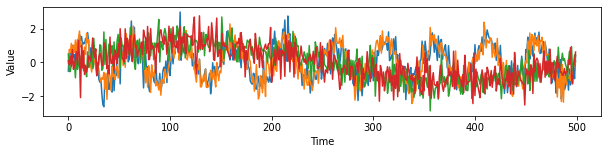

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [7]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [8]:
dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

In [9]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 4.271, mse= 3.883, kld= 3.872
	val_loss= 4.293, val_mse= 4.011, val_kld= 2.819
Epoch= 11/200, loss= 3.433, mse= 3.378, kld= 0.558
	val_loss= 3.496, val_mse= 3.442, val_kld= 0.541
Epoch= 21/200, loss= 3.178, mse= 3.113, kld= 0.650
	val_loss= 3.488, val_mse= 3.395, val_kld= 0.936
Epoch= 31/200, loss= 2.949, mse= 2.880, kld= 0.691
	val_loss= 2.554, val_mse= 2.467, val_kld= 0.870
Epoch= 41/200, loss= 2.452, mse= 2.348, kld= 1.046
	val_loss= 2.582, val_mse= 2.503, val_kld= 0.789
Epoch= 51/200, loss= 2.222, mse= 2.127, kld= 0.952
	val_loss= 2.279, val_mse= 2.204, val_kld= 0.750
Epoch= 61/200, loss= 1.990, mse= 1.887, kld= 1.029
	val_loss= 2.309, val_mse= 2.229, val_kld= 0.806
Epoch= 71/200, loss= 1.965, mse= 1.858, kld= 1.072
	val_loss= 1.939, val_mse= 1.855, val_kld= 0.838
Epoch= 81/200, loss= 1.742, mse= 1.637, kld= 1.051
	val_loss= 1.722, val_mse= 1.599, val_kld= 1.234
Epoch= 91/200, loss= 1.667, mse= 1.564, kld= 1.035
	val_loss= 1.576, val_mse= 1.477, val_kld= 0.986
E

<AxesSubplot:xlabel='Epoch'>

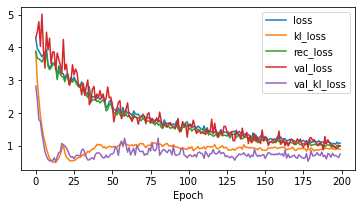

In [10]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

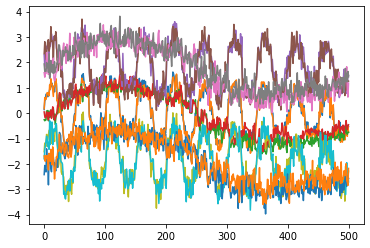

In [11]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

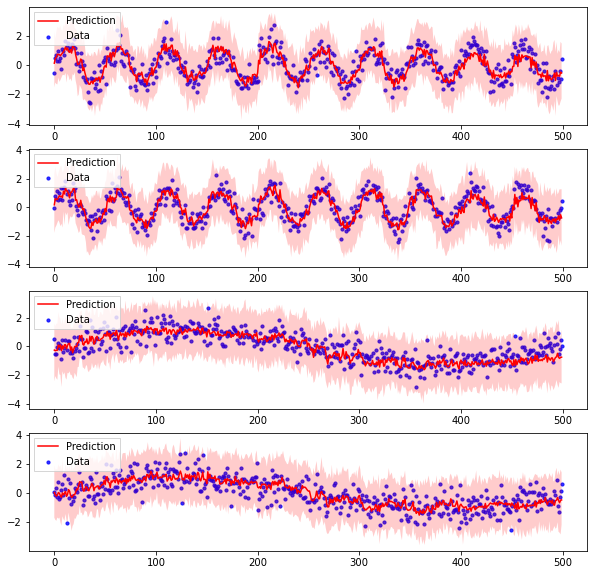

In [12]:
fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

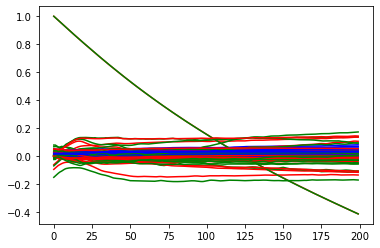

In [13]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

# Moja praca

## Wczytanie danych

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import torch

In [15]:


#FIRST on 10 000 workouts - train 9000, test 1000
data_endo = []
i = 0
#with gzip.open('endomondoHR.json.gz') as f:

with open('endomondoHR_proper.json') as f:
    for l in f:
        i += 1
        #print(i)
        data_endo.append(eval(l))
        if i == 10000:
            break
        #print(data[0])

## Wstępne wykresy

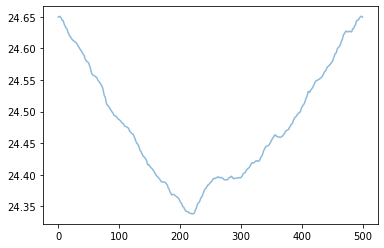

In [16]:

# Plot ithmeasurement x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

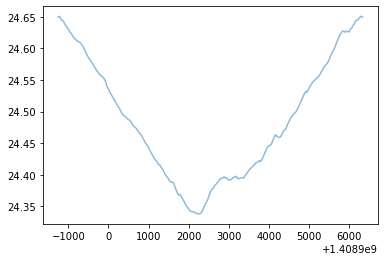

In [17]:

# Plot timestamp x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)


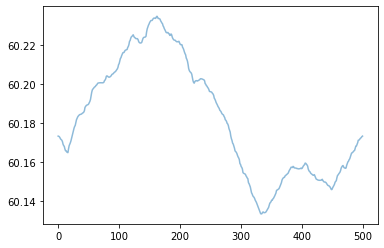

In [18]:

# Plot ithmeasurement x latitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['latitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

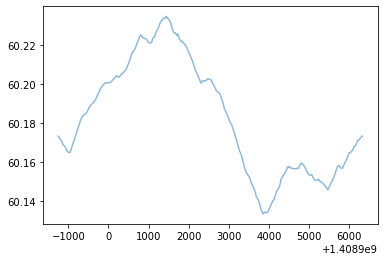

In [19]:

# Plot timestamp x latitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['latitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)


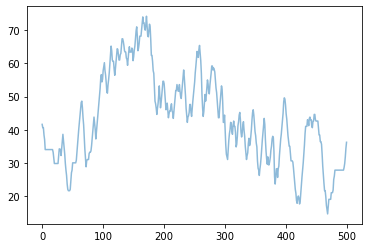

In [20]:

# Plot ithmeasurement x altitude

#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['altitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

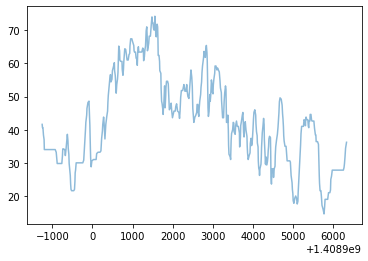

In [21]:

# Plot timestamp x altitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['altitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

In [22]:
####OK wykresy sie zgadzaja

In [23]:
###TERAZ TRENUJEMY DLA 1 WORKOUTU LONGITUDE,TRAIN TO PIERWSZE 450 A VAL TO KOLEJNE 50

In [24]:
#### ITHMEASUREMENT vs LONGITUDE

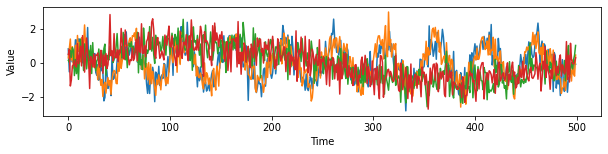

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [25]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)
#print(data.shape[1])

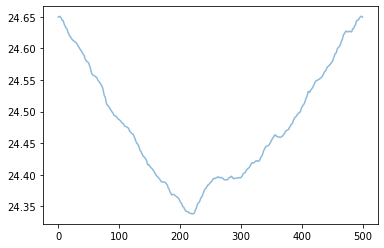

In [26]:

# Plot ithmeasurement x longitude



#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

## Trenowane dla 1 treningu po longitude

In [254]:
#x = torch.FloatTensor(data).reshape(1, *data.shape)
#x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])

y_data = torch.FloatTensor(y).reshape(1, 500, 1)
#print(y_data)
y_train = torch.FloatTensor(y[:450]).reshape(1, 450, 1)
#print(y_train)
y_val = torch.FloatTensor(y[450:500]).reshape(1, 50, 1)
#print(y_val)


RuntimeError: shape '[1, 500, 1]' is invalid for input of size 2500

In [255]:
dkf = DKF(input_dim=1, z_dim=5, rnn_dim=5, trans_dim=5, emission_dim=5)

In [29]:
history, param_dict = dkf.fit(y_train, y_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 598.310, mse= 597.670, kld= 6.399
	val_loss= 598.161, val_mse= 597.689, val_kld= 4.722
Epoch= 11/200, loss= 569.461, mse= 569.221, kld= 2.396
	val_loss= 566.285, val_mse= 565.997, val_kld= 2.880
Epoch= 21/200, loss= 372.314, mse= 370.775, kld= 15.384
	val_loss= 313.220, val_mse= 311.426, val_kld= 17.938
Epoch= 31/200, loss= 75.343, mse= 74.993, kld= 3.504
	val_loss= 71.482, val_mse= 71.144, val_kld= 3.376
Epoch= 41/200, loss= 8.378, mse= 7.971, kld= 4.078
	val_loss= 6.359, val_mse= 5.888, val_kld= 4.706
Epoch= 51/200, loss= 3.657, mse= 3.252, kld= 4.057
	val_loss= 3.658, val_mse= 3.185, val_kld= 4.727
Epoch= 61/200, loss= 2.583, mse= 2.255, kld= 3.285
	val_loss= 2.774, val_mse= 2.354, val_kld= 4.198
Epoch= 71/200, loss= 2.284, mse= 2.006, kld= 2.774
	val_loss= 2.340, val_mse= 1.966, val_kld= 3.739
Epoch= 81/200, loss= 2.144, mse= 1.905, kld= 2.380
	val_loss= 2.607, val_mse= 2.255, val_kld= 3.519
Epoch= 91/200, loss= 1.748, mse= 1.545, kld= 2.034
	val_loss= 1.886, va

<AxesSubplot:xlabel='Epoch'>

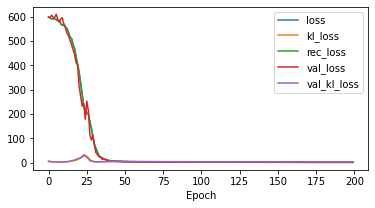

In [30]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

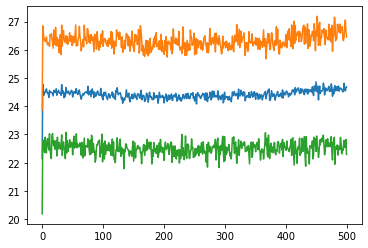

In [31]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(y_data, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

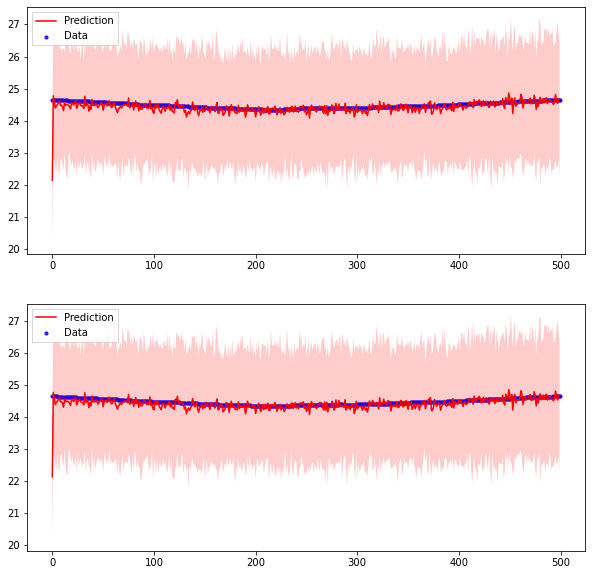

In [32]:
fig, ax = plt.subplots(2, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(y.shape[0]),
        y[:], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, 0], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, 0], x_975[:, 0],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [33]:

mse_values = mean_squared_error(y_data[0], x_hat)
r_squared_values = r2_score(y_data[0], x_hat)
mae_values = mean_absolute_error(y_data[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(y_data[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(y_data[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(y_data[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

print(x_hat.shape)

             MSE  R-squared       MAE
Average  0.02626  -2.107979  0.100009
             MSE  R-squared       MAE
sample1  0.02626  -2.107979  0.100009
(500, 1)


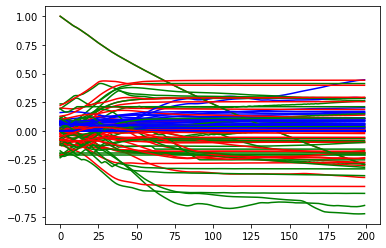

In [34]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [35]:
###################################################################################################################

In [36]:
####################################################################################################################

In [37]:
#TUTAJ TRENUJEMY DKF'a dla 1szego WORKOUTU 3 na RAZ LON LAT ALT

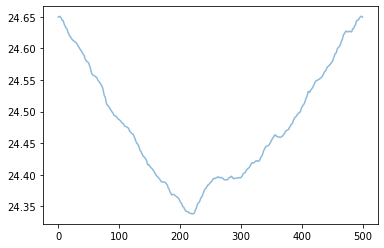

(500, 3)


In [38]:

# Plot ithmeasurement x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)





first_workout_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[0]['latitude']), np.asarray(data_endo[0]['altitude'])]).T
print(first_workout_data.shape)

## Trenowane dla pierwszego treningu po longitude, latitude i altitude

In [259]:
first_workout_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[0]['latitude']), np.asarray(data_endo[0]['altitude'])]).T
print(first_workout_data.shape)
x = torch.FloatTensor(first_workout_data).reshape(1, *first_workout_data.shape)
#print(x)
x_train = torch.FloatTensor(first_workout_data[:450]).reshape(1, 450, first_workout_data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(first_workout_data[450:500]).reshape(1, 50, first_workout_data.shape[1])
#print(x_val)

(500, 3)


In [260]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [261]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 2125.558, mse= 2100.376, kld= 251.818
	val_loss= 1614.219, val_mse= 1612.437, val_kld= 17.822
Epoch= 11/200, loss= 335.138, mse= 330.006, kld= 51.315
	val_loss= 241.095, val_mse= 234.507, val_kld= 65.879
Epoch= 21/200, loss= 81.112, mse= 77.308, kld= 38.034
	val_loss= 80.880, val_mse= 76.634, val_kld= 42.456
Epoch= 31/200, loss= 80.049, mse= 77.573, kld= 24.761
	val_loss= 136.020, val_mse= 132.926, val_kld= 30.944
Epoch= 41/200, loss= 63.648, mse= 62.169, kld= 14.794
	val_loss= 109.398, val_mse= 107.287, val_kld= 21.116
Epoch= 51/200, loss= 54.187, mse= 53.083, kld= 11.039
	val_loss= 121.494, val_mse= 119.705, val_kld= 17.886
Epoch= 61/200, loss= 49.251, mse= 48.414, kld= 8.362
	val_loss= 102.055, val_mse= 100.462, val_kld= 15.934
Epoch= 71/200, loss= 48.288, mse= 47.619, kld= 6.691
	val_loss= 98.979, val_mse= 97.515, val_kld= 14.646
Epoch= 81/200, loss= 45.827, mse= 45.241, kld= 5.862
	val_loss= 100.392, val_mse= 98.985, val_kld= 14.071
Epoch= 91/200, loss= 42.866,

<AxesSubplot:xlabel='Epoch'>

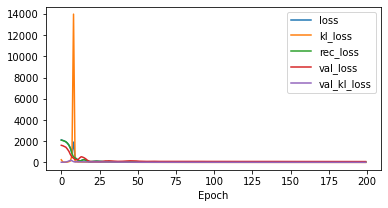

In [262]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

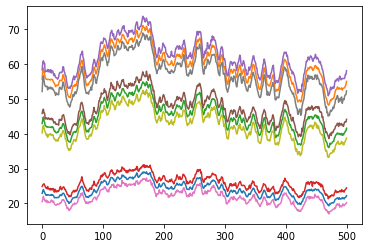

In [263]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

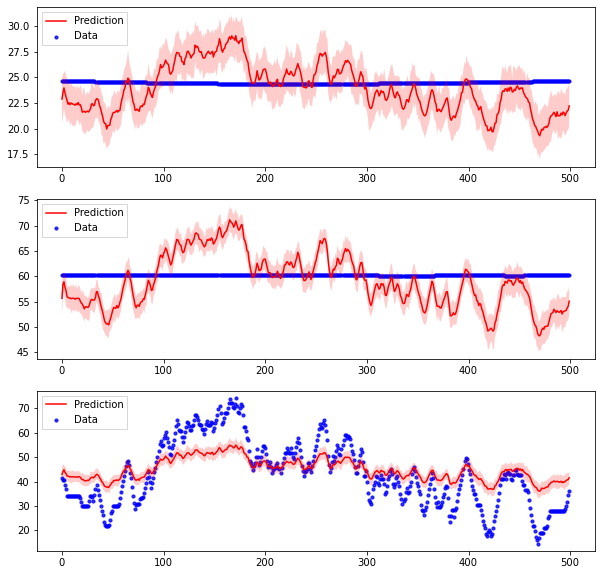

In [264]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(first_workout_data.shape[0]),
        first_workout_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [265]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE     R-squared       MAE
Average  40.259495 -11044.608507  4.759365
\begin{tabular}{lrrr}
\toprule
{} &        MSE &     R-squared &       MAE \\
\midrule
Average &  40.259495 & -11044.608507 &  4.759365 \\
\bottomrule
\end{tabular}

               MSE     R-squared       MAE
sample1   5.732484   -677.470359  2.017633
sample2  29.108948 -32456.881940  4.510141
sample3  85.937050      0.526778  7.750319


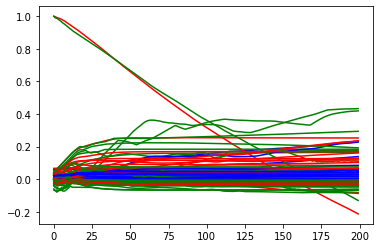

In [51]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
###################################################################################################################

In [ ]:
####################################################################################################################

In [ ]:
#TERAZ DKF DLA LONGITUDE DLA 3 PIERWSZYCH WORKOUTOW

## Trenowane dla 3 pierwszych treningow po longitude

In [232]:
longitude_three_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[1]['longitude']), np.asarray(data_endo[2]['longitude'])]).T
#print(first_workout_data.shape)

In [233]:
x = torch.FloatTensor(longitude_three_data).reshape(1, *longitude_three_data.shape)
#print(x)
x_train = torch.FloatTensor(longitude_three_data[:450]).reshape(1, 450, longitude_three_data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(longitude_three_data[450:500]).reshape(1, 50, longitude_three_data.shape[1])
#print(x_val)

In [234]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [235]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 605.624, mse= 603.660, kld= 19.641
	val_loss= 601.032, val_mse= 599.825, val_kld= 12.068
Epoch= 11/200, loss= 154.345, mse= 147.675, kld= 66.700
	val_loss= 86.062, val_mse= 79.451, val_kld= 66.113
Epoch= 21/200, loss= 25.587, mse= 23.978, kld= 16.090
	val_loss= 35.833, val_mse= 33.376, val_kld= 24.570
Epoch= 31/200, loss= 8.749, mse= 7.583, kld= 11.658
	val_loss= 6.443, val_mse= 4.633, val_kld= 18.098
Epoch= 41/200, loss= 6.164, mse= 5.387, kld= 7.778
	val_loss= 7.751, val_mse= 6.649, val_kld= 11.017
Epoch= 51/200, loss= 3.009, mse= 2.385, kld= 6.243
	val_loss= 3.233, val_mse= 2.492, val_kld= 7.413
Epoch= 61/200, loss= 2.689, mse= 2.208, kld= 4.809
	val_loss= 3.262, val_mse= 2.684, val_kld= 5.784
Epoch= 71/200, loss= 2.234, mse= 1.830, kld= 4.039
	val_loss= 2.538, val_mse= 2.033, val_kld= 5.045
Epoch= 81/200, loss= 2.042, mse= 1.698, kld= 3.444
	val_loss= 1.908, val_mse= 1.485, val_kld= 4.227
Epoch= 91/200, loss= 1.739, mse= 1.396, kld= 3.425
	val_loss= 1.971, val_m

<AxesSubplot:xlabel='Epoch'>

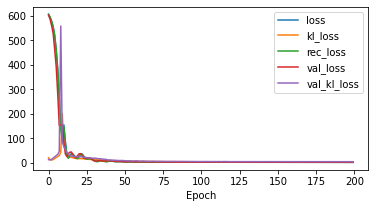

In [236]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

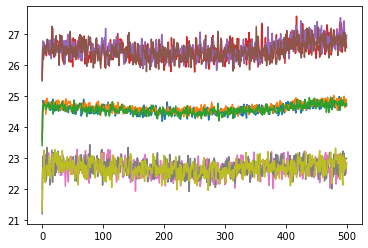

In [237]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

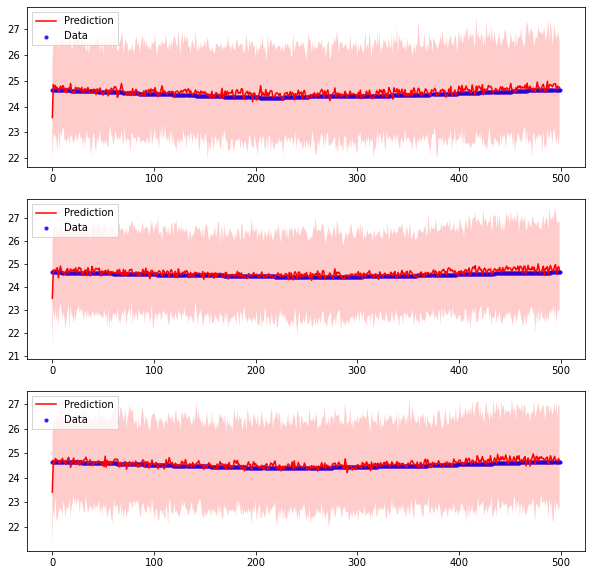

In [238]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(longitude_three_data.shape[0]),
        longitude_three_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [239]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

              MSE  R-squared       MAE
Average  0.019957  -2.544409  0.108569
\begin{tabular}{lrrr}
\toprule
{} &       MSE &  R-squared &       MAE \\
\midrule
Average &  0.019957 &  -2.544409 &  0.108569 \\
\bottomrule
\end{tabular}

              MSE  R-squared       MAE
sample1  0.021532  -1.548472  0.116012
sample2  0.020454  -4.403859  0.110501
sample3  0.017883  -1.680896  0.099195


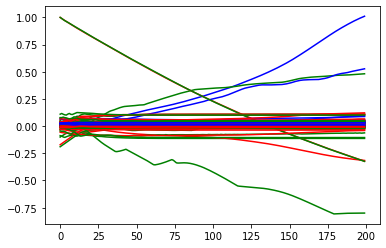

In [60]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
####################################################################################################################

In [ ]:
####################################################################################################################

In [ ]:
#TUTAJ DKF PO ALTITUDE DLA 5 WORKOUTOW

## Trenowane dla 5 pierwszych treningow po altitude

In [224]:
data = np.vstack([np.asarray(data_endo[0]['altitude']), np.asarray(data_endo[1]['altitude']), 
                  np.asarray(data_endo[2]['altitude']), np.asarray(data_endo[3]['altitude']),
                  np.asarray(data_endo[4]['altitude'])]).T
#print(data.shape)

In [225]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:450]).reshape(1, 450, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[450:500]).reshape(1, 50, data.shape[1])
#print(x_val)

In [226]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [227]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 1987.508, mse= 1984.709, kld= 27.991
	val_loss= 852.505, val_mse= 851.645, val_kld= 8.599
Epoch= 11/200, loss= 513.156, mse= 508.864, kld= 42.928
	val_loss= 137.181, val_mse= 135.127, val_kld= 20.541
Epoch= 21/200, loss= 133.851, mse= 131.442, kld= 24.094
	val_loss= 36.568, val_mse= 34.893, val_kld= 16.750
Epoch= 31/200, loss= 128.227, mse= 126.468, kld= 17.591
	val_loss= 67.041, val_mse= 65.805, val_kld= 12.359
Epoch= 41/200, loss= 103.091, mse= 101.692, kld= 13.990
	val_loss= 34.319, val_mse= 33.260, val_kld= 10.588
Epoch= 51/200, loss= 91.953, mse= 90.757, kld= 11.958
	val_loss= 27.375, val_mse= 26.459, val_kld= 9.153
Epoch= 61/200, loss= 87.383, mse= 86.383, kld= 10.000
	val_loss= 32.790, val_mse= 31.981, val_kld= 8.089
Epoch= 71/200, loss= 84.951, mse= 84.075, kld= 8.760
	val_loss= 28.754, val_mse= 28.027, val_kld= 7.269
Epoch= 81/200, loss= 82.240, mse= 81.456, kld= 7.841
	val_loss= 31.217, val_mse= 30.516, val_kld= 7.008
Epoch= 91/200, loss= 82.063, mse= 81.3

<AxesSubplot:xlabel='Epoch'>

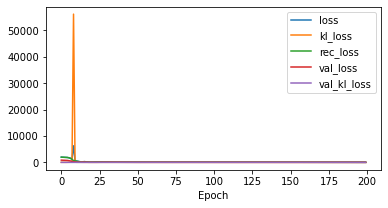

In [228]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

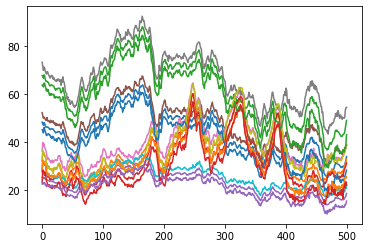

In [229]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

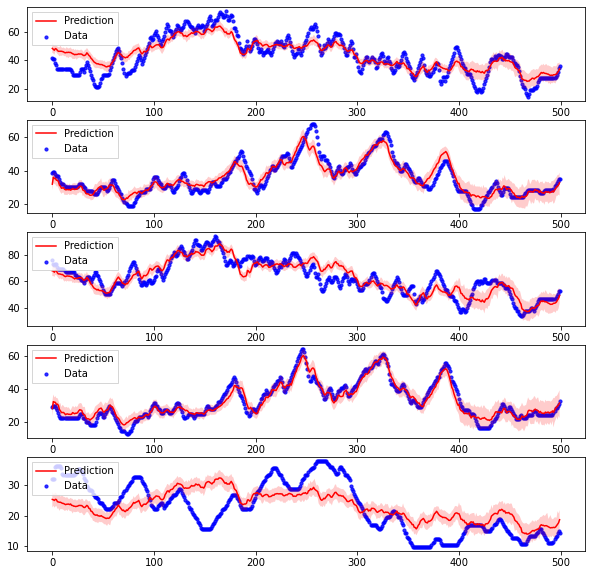

In [230]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [231]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  32.101151   0.727443  4.416904
\begin{tabular}{lrrr}
\toprule
{} &        MSE &  R-squared &       MAE \\
\midrule
Average &  32.101151 &   0.727443 &  4.416904 \\
\bottomrule
\end{tabular}

               MSE  R-squared       MAE
sample1  43.821419   0.758693  5.361005
sample2  15.253545   0.858321  2.998376
sample3  47.403366   0.728663  5.555529
sample4   9.184316   0.929546  2.523679
sample5  44.843105   0.361991  5.645933


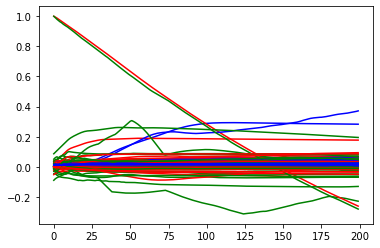

In [69]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
####################################################################################################################

In [ ]:
#Preparing test synthetic datasets - each 1000 measurements

# Przygotowanie danych syntetycznych

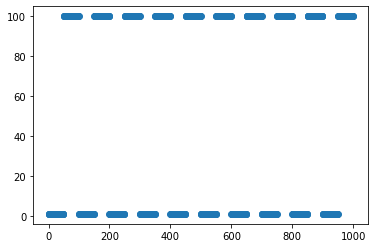

In [203]:
#Dataset 1 - binary a bunch of 1's then a bunch of 100's
data_bin = []
while len(data_bin)<1000:
    data_bin.extend([1 for i in range(50)])
    data_bin.extend([100 for i in range(50)])
data_bin = np.asarray(data_bin[:1000])
#print(data_bin)
plt.scatter(range(len(data_bin)),data_bin)
plt.show()



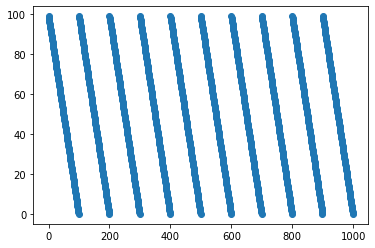

In [204]:
#Dataset 2 - Decreasing from 100 to 1 in a loop
data_spike = []
while len(data_spike)<1000:
    data_spike.extend([-i + 100 for i in range(1, 101)])
    
data_spike = np.asarray(data_spike[:1000])
#print(data_spike)
plt.scatter(range(len(data_spike)), data_spike)
plt.show()

In [205]:
#Dataset 3 - Growing from 1 to 100 then from 100 to 1

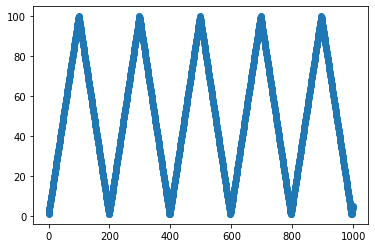

In [206]:
data_alt = []
while len(data_alt)<1000:
    data_alt.extend([i for i in range(1,100)])
    data_alt.extend([i for i in range(100,0,-1)])
    
data_alt = np.asarray(data_alt[:1000])
#print(data_alt)
plt.scatter(range(len(data_alt)), data_alt)
plt.show()

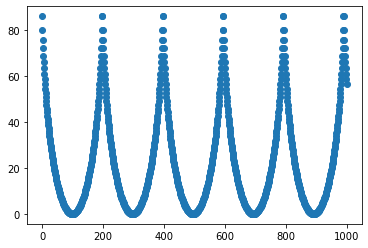

In [207]:
#Dataset 4 - Lower half of a circle
data_circle = []
while len(data_circle)<1000:
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(99,0,-1)])
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(1,100)])
    
data_circle = np.asarray(data_circle[:1000])
#print(data_circle)
#print(len(data_circle))
plt.scatter(range(len(data_circle)), data_circle)
plt.show()

In [208]:
data = np.vstack([data_bin, data_spike, data_alt, data_circle]).T
#print(data.shape)

In [209]:
data = np.vstack([data_bin, data_spike, data_alt, data_circle]).T
#print(data.shape)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:600]).reshape(1, 600, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[600:800]).reshape(1, 200, data.shape[1])
#print(x_val)

## Trenowanie dla danych syntetycznych

In [210]:
dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

In [212]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

Epoch= 1/200, loss= 3103.585, mse= 3082.687, kld= 104.492
	val_loss= 3032.255, val_mse= 3016.048, val_kld= 81.037
Epoch= 11/200, loss= 1801.443, mse= 1791.311, kld= 50.657
	val_loss= 1605.412, val_mse= 1596.344, val_kld= 45.341
Epoch= 21/200, loss= 1010.962, mse= 1003.104, kld= 39.290
	val_loss= 979.629, val_mse= 971.657, val_kld= 39.860
Epoch= 31/200, loss= 687.888, mse= 680.389, kld= 37.494
	val_loss= 653.240, val_mse= 645.673, val_kld= 37.833
Epoch= 41/200, loss= 382.475, mse= 374.957, kld= 37.590
	val_loss= 372.670, val_mse= 365.215, val_kld= 37.275
Epoch= 51/200, loss= 350.806, mse= 344.543, kld= 31.316
	val_loss= 335.394, val_mse= 329.217, val_kld= 30.887
Epoch= 61/200, loss= 314.052, mse= 308.587, kld= 27.327
	val_loss= 304.911, val_mse= 299.487, val_kld= 27.121
Epoch= 71/200, loss= 287.935, mse= 283.007, kld= 24.637
	val_loss= 273.569, val_mse= 268.633, val_kld= 24.681
Epoch= 81/200, loss= 244.999, mse= 240.373, kld= 23.129
	val_loss= 226.138, val_mse= 221.576, val_kld= 22.811


<AxesSubplot:xlabel='Epoch'>

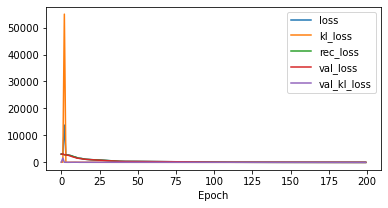

In [213]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

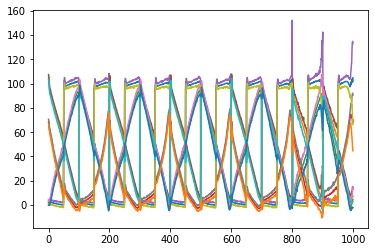

In [214]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

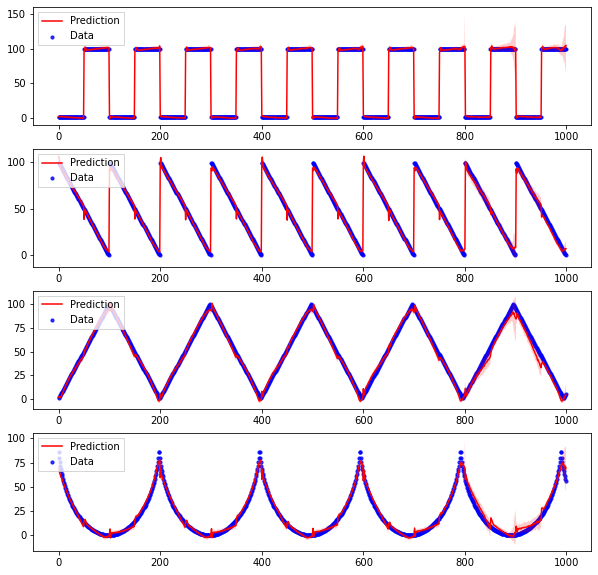

In [215]:
fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [216]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  21.112291   0.980398  1.964865
\begin{tabular}{lrrr}
\toprule
{} &        MSE &  R-squared &       MAE \\
\midrule
Average &  21.112291 &   0.980398 &  1.964865 \\
\bottomrule
\end{tabular}

               MSE  R-squared       MAE
sample1  41.102306   0.983225  1.332512
sample2  21.323195   0.974410  1.630973
sample3  10.461822   0.987427  2.412330
sample4  11.561845   0.976529  2.483646


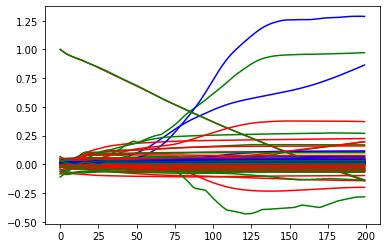

In [83]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
#################################################################################

# Przesuniecie i normalizacja danych

## Trenowanie dla pierwszych 5 treningow po przesunieciu w plaszczyznie longitude x latitude

In [196]:
#5 Workoutow, gdzie zbijamy longitude i latitude w przesuniecie



def translation(i):
    lon = np.asarray(data_endo[i]['longitude'])
    lat = np.asarray(data_endo[i]['latitude'])
    tra = np.sqrt(np.power(lon, 2) + np.power(lat,2))
    return tra

data = np.vstack( [translation(i) for i in range(5)]).T
#print(data.shape)

In [197]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [198]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [199]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

Epoch= 1/200, loss= 4281.489, mse= 4186.924, kld= 472.821
	val_loss= 4175.386, val_mse= 4164.846, val_kld= 52.700
Epoch= 11/200, loss= 323.756, mse= 312.592, kld= 55.821
	val_loss= 630.445, val_mse= 619.519, val_kld= 54.629
Epoch= 21/200, loss= 174.812, mse= 167.804, kld= 35.040
	val_loss= 130.126, val_mse= 120.932, val_kld= 45.971
Epoch= 31/200, loss= 60.691, mse= 54.246, kld= 32.224
	val_loss= 62.557, val_mse= 54.303, val_kld= 41.270
Epoch= 41/200, loss= 19.894, mse= 14.286, kld= 28.040
	val_loss= 27.149, val_mse= 19.597, val_kld= 37.763
Epoch= 51/200, loss= 11.449, mse= 6.548, kld= 24.506
	val_loss= 11.904, val_mse= 4.762, val_kld= 35.710
Epoch= 61/200, loss= 10.425, mse= 6.074, kld= 21.752
	val_loss= 10.499, val_mse= 4.146, val_kld= 31.765
Epoch= 71/200, loss= 7.122, mse= 3.219, kld= 19.515
	val_loss= 8.732, val_mse= 2.717, val_kld= 30.078
Epoch= 81/200, loss= 6.134, mse= 2.724, kld= 17.050
	val_loss= 8.205, val_mse= 2.784, val_kld= 27.103
Epoch= 91/200, loss= 5.135, mse= 2.260, kl

<AxesSubplot:xlabel='Epoch'>

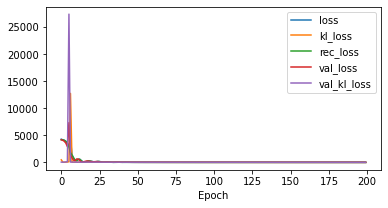

In [200]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

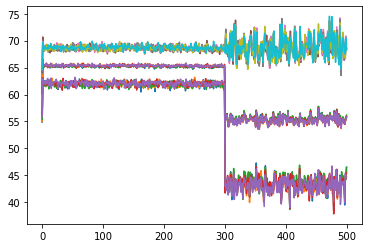

In [189]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

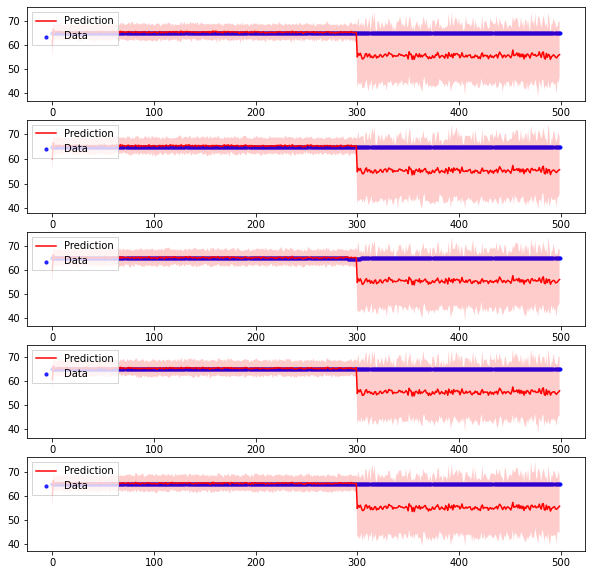

In [201]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [202]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE     R-squared       MAE
Average  37.476048 -51632.292738  4.059708
\begin{tabular}{lrrr}
\toprule
{} &        MSE &     R-squared &       MAE \\
\midrule
Average &  37.476048 & -51632.292738 &  4.059708 \\
\bottomrule
\end{tabular}

               MSE     R-squared       MAE
sample1  36.641869 -30043.328039  3.973397
sample2  38.338684 -57663.934730  4.138187
sample3  35.704746 -26483.434397  3.953044
sample4  37.804928 -58381.931335  4.094353
sample5  38.889999 -85588.835190  4.139558


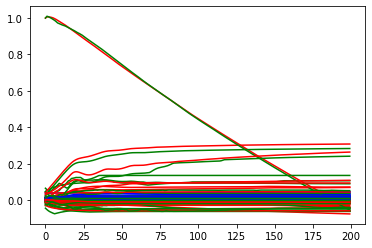

In [113]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [114]:
##########################################################################################################

## Trenowane dla znormalizowanych latitude i longitude

In [176]:
#Normalizacja dla 2D - latitude i longitude


def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))

norm_long = NormalizeData(np.asarray(data_endo[0]['longitude']))
norm_lat  = NormalizeData(np.asarray(data_endo[0]['latitude']))
#norm_alt  = NormalizeData(np.asarray(data_endo[0]['altitude']))

data = np.vstack([norm_long, norm_lat]).T
#print(data.shape)


In [177]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [178]:
dkf = DKF(input_dim=2, z_dim=10, rnn_dim=10, trans_dim=10, emission_dim=10)

In [179]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 3073.942, mse= 2907.103, kld= 1668.387
	val_loss= 2423.336, val_mse= 2416.287, val_kld= 70.484
Epoch= 11/200, loss= 2554.540, mse= 2552.819, kld= 17.217
	val_loss= 1993.320, val_mse= 1992.028, val_kld= 12.924
Epoch= 21/200, loss= 790.990, mse= 788.607, kld= 23.834
	val_loss= 669.682, val_mse= 667.913, val_kld= 17.692
Epoch= 31/200, loss= 572.144, mse= 571.119, kld= 10.250
	val_loss= 1057.885, val_mse= 1056.625, val_kld= 12.602
Epoch= 41/200, loss= 505.768, mse= 504.676, kld= 10.914
	val_loss= 1288.515, val_mse= 1287.296, val_kld= 12.190
Epoch= 51/200, loss= 464.919, mse= 464.041, kld= 8.780
	val_loss= 1042.430, val_mse= 1041.401, val_kld= 10.291
Epoch= 61/200, loss= 460.958, mse= 460.182, kld= 7.763
	val_loss= 1047.567, val_mse= 1046.612, val_kld= 9.545
Epoch= 71/200, loss= 461.760, mse= 461.013, kld= 7.466
	val_loss= 1129.007, val_mse= 1128.089, val_kld= 9.177
Epoch= 81/200, loss= 458.912, mse= 458.205, kld= 7.071
	val_loss= 1131.593, val_mse= 1130.691, val_kld= 9.

<AxesSubplot:xlabel='Epoch'>

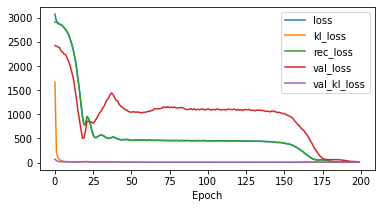

In [180]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

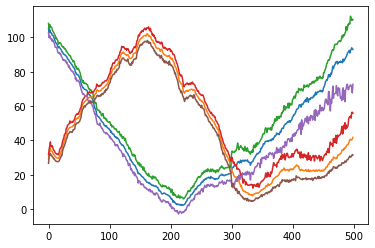

In [181]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

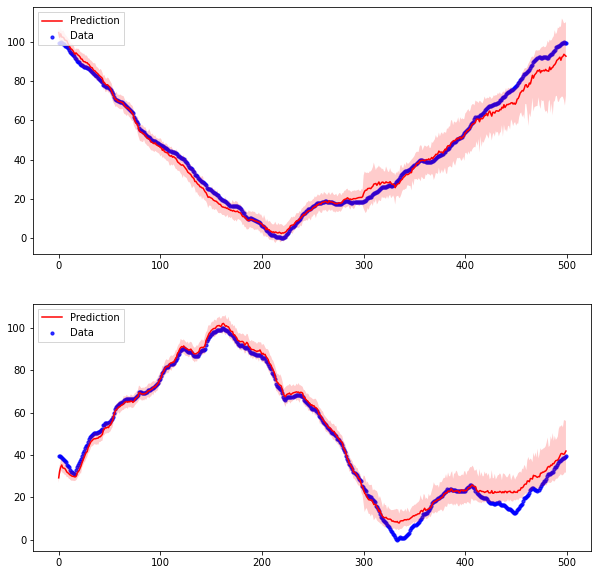

In [182]:
fig, ax = plt.subplots(2, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [183]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

              MSE  R-squared       MAE
Average  10.44821   0.987938  2.417282
\begin{tabular}{lrrr}
\toprule
{} &       MSE &  R-squared &       MAE \\
\midrule
Average &  10.44821 &   0.987938 &  2.417282 \\
\bottomrule
\end{tabular}

               MSE  R-squared       MAE
sample1  10.522655   0.987777  2.483699
sample2  10.373765   0.988099  2.350865


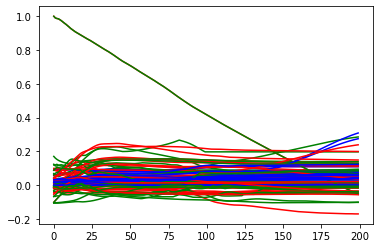

In [123]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
#Normalizacja dla 3D - latitude, longitude i altitude

## Trenowanie dla znormalizowanych danych longitude, latitude, altitude

In [168]:
def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))

norm_long = NormalizeData(np.asarray(data_endo[0]['longitude']))
norm_lat  = NormalizeData(np.asarray(data_endo[0]['latitude']))
norm_alt  = NormalizeData(np.asarray(data_endo[0]['altitude']))

data = np.vstack([norm_long, norm_lat, norm_alt]).T
#print(data.shape)


In [169]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [170]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [171]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.15)

Epoch= 1/200, loss= 3085.455, mse= 3064.643, kld= 138.744
	val_loss= 2032.366, val_mse= 2026.703, val_kld= 37.754
Epoch= 11/200, loss= 1277.940, mse= 1272.972, kld= 33.115
	val_loss= 738.841, val_mse= 732.733, val_kld= 40.719
Epoch= 21/200, loss= 587.785, mse= 584.169, kld= 24.106
	val_loss= 879.746, val_mse= 875.872, val_kld= 25.823
Epoch= 31/200, loss= 430.904, mse= 427.339, kld= 23.768
	val_loss= 875.803, val_mse= 871.542, val_kld= 28.409
Epoch= 41/200, loss= 429.315, mse= 426.633, kld= 17.882
	val_loss= 782.733, val_mse= 779.386, val_kld= 22.315
Epoch= 51/200, loss= 398.263, mse= 396.194, kld= 13.797
	val_loss= 817.254, val_mse= 814.196, val_kld= 20.388
Epoch= 61/200, loss= 365.336, mse= 363.351, kld= 13.233
	val_loss= 735.988, val_mse= 733.289, val_kld= 17.999
Epoch= 71/200, loss= 261.054, mse= 259.206, kld= 12.321
	val_loss= 422.326, val_mse= 419.287, val_kld= 20.262
Epoch= 81/200, loss= 97.410, mse= 95.147, kld= 15.082
	val_loss= 127.294, val_mse= 123.759, val_kld= 23.565
Epoch=

<AxesSubplot:xlabel='Epoch'>

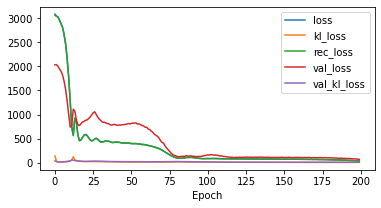

In [172]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

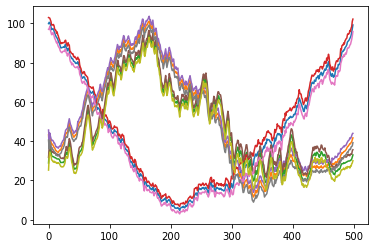

In [173]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

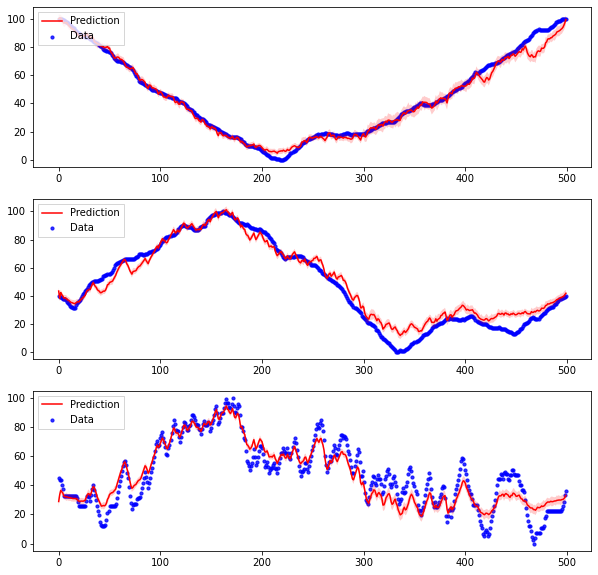

In [174]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [175]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared      MAE
Average  41.885201   0.932859  4.74778
\begin{tabular}{lrrr}
\toprule
{} &        MSE &  R-squared &      MAE \\
\midrule
Average &  41.885201 &   0.932859 &  4.74778 \\
\bottomrule
\end{tabular}

               MSE  R-squared       MAE
sample1  15.127951   0.982428  2.450215
sample2  39.989792   0.954125  5.045236
sample3  70.537857   0.862025  6.747889


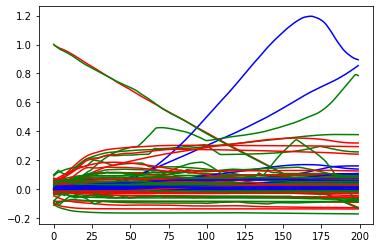

In [132]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
############################################################################################################

In [ ]:
#5 Workoutow ze znormalizowanym altitude

## 5 treningow z znormalizowanym altitude

In [160]:
def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))


data = np.vstack([NormalizeData(np.asarray(data_endo[i]['altitude'])) for i in range(5)]).T
print(data.shape)

print(data)

(500, 5)
[[45.30201342 41.8972332  70.95709571 31.39534884 79.28571429]
 [43.62416107 43.08300395 65.67656766 32.94573643 79.28571429]
 [43.62416107 43.08300395 64.35643564 32.94573643 79.28571429]
 ...
 [28.8590604  33.59683794 27.72277228 33.72093023 16.42857143]
 [33.22147651 35.17786561 32.01320132 35.65891473 18.57142857]
 [36.24161074 35.17786561 32.01320132 39.53488372 15.71428571]]


In [161]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [162]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [163]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.15)

Epoch= 1/200, loss= 3236.796, mse= 2956.270, kld= 1870.171
	val_loss= 799.362, val_mse= 796.403, val_kld= 19.727
Epoch= 11/200, loss= 789.382, mse= 776.524, kld= 85.717
	val_loss= 187.235, val_mse= 180.788, val_kld= 42.977
Epoch= 21/200, loss= 400.474, mse= 392.798, kld= 51.179
	val_loss= 143.264, val_mse= 138.901, val_kld= 29.087
Epoch= 31/200, loss= 323.242, mse= 316.925, kld= 42.112
	val_loss= 133.166, val_mse= 129.085, val_kld= 27.204
Epoch= 41/200, loss= 253.895, mse= 248.501, kld= 35.966
	val_loss= 127.493, val_mse= 123.450, val_kld= 26.953
Epoch= 51/200, loss= 207.987, mse= 203.195, kld= 31.946
	val_loss= 122.474, val_mse= 118.732, val_kld= 24.947
Epoch= 61/200, loss= 182.216, mse= 177.890, kld= 28.837
	val_loss= 116.443, val_mse= 112.986, val_kld= 23.046
Epoch= 71/200, loss= 175.891, mse= 172.004, kld= 25.913
	val_loss= 104.446, val_mse= 101.177, val_kld= 21.795
Epoch= 81/200, loss= 171.663, mse= 167.969, kld= 24.627
	val_loss= 102.249, val_mse= 99.165, val_kld= 20.562
Epoch= 9

<AxesSubplot:xlabel='Epoch'>

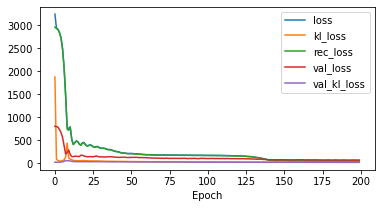

In [164]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

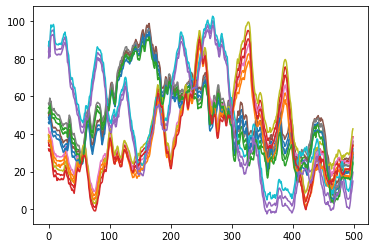

In [165]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

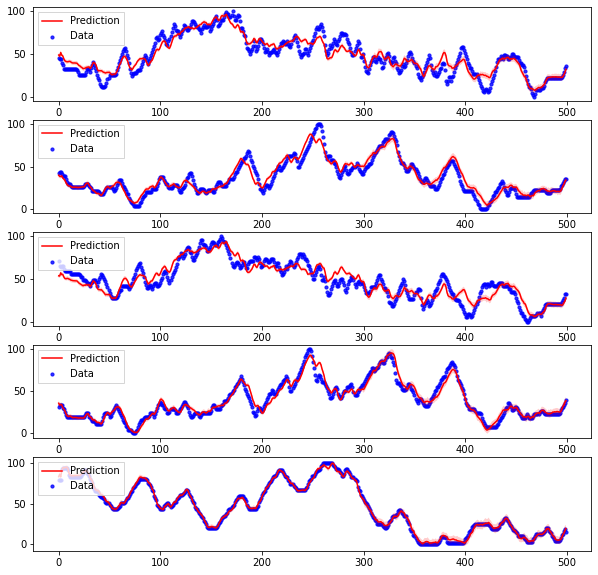

In [166]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [167]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  44.636532    0.90728  4.923034
\begin{tabular}{lrrr}
\toprule
{} &        MSE &  R-squared &       MAE \\
\midrule
Average &  44.636532 &    0.90728 &  4.923034 \\
\bottomrule
\end{tabular}

               MSE  R-squared       MAE
sample1  70.620079   0.861865  6.852356
sample2  38.117062   0.909353  4.774132
sample3  81.483719   0.828716  7.385866
sample4  28.870722   0.941032  3.998817
sample5   4.091084   0.995437  1.603994


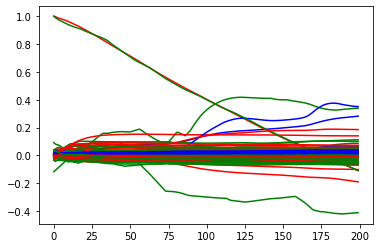

In [182]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

## Syntetyczne zaszumione

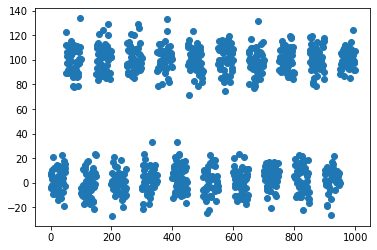

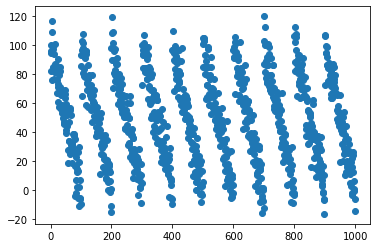

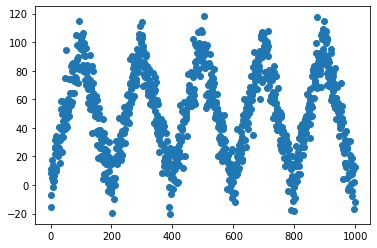

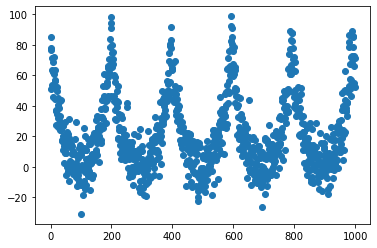

In [146]:
#Dataset 1 - binary a bunch of 1's then a bunch of 100's
data_bin = []
while len(data_bin)<1000:
    data_bin.extend([1 for i in range(50)])
    data_bin.extend([100 for i in range(50)])
data_bin = np.asarray(data_bin[:1000]) 
data_bin =  data_bin + np.random.normal(0, 10, size = data_bin.shape)
#print(data_bin)
plt.scatter(range(len(data_bin)),data_bin)
plt.show()



#Dataset 2 - Decreasing from 100 to 1 in a loop
data_spike = []
while len(data_spike)<1000:
    data_spike.extend([-i + 100 for i in range(1, 101)])
    
data_spike = np.asarray(data_spike[:1000])
data_spike = data_spike + np.random.normal(0,10, size = data_spike.shape)
#print(data_spike)
plt.scatter(range(len(data_spike)), data_spike)
plt.show()

#Dataset 3 - Growing from 1 to 100 then from 100 to 1

data_alt = []
while len(data_alt)<1000:
    data_alt.extend([i for i in range(1,100)])
    data_alt.extend([i for i in range(100,0,-1)])
    
data_alt = np.asarray(data_alt[:1000])
data_alt = data_alt + np.random.normal(0, 10, size = data_alt.shape)
#print(data_alt)
plt.scatter(range(len(data_alt)), data_alt)
plt.show()

#Dataset 4 - Lower half of a circle
data_circle = []
while len(data_circle)<1000:
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(99,0,-1)])
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(1,100)])
    
data_circle = np.asarray(data_circle[:1000])
data_circle = data_circle + np.random.normal(0, 10, size = data_circle.shape)
#print(data_circle)
#print(len(data_circle))
plt.scatter(range(len(data_circle)), data_circle)
plt.show()

data = np.vstack([data_bin, data_spike, data_alt, data_circle]).T
#print(data.shape)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:600]).reshape(1, 600, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[600:800]).reshape(1, 200, data.shape[1])
#print(x_val)



Epoch= 1/200, loss= 3374.239, mse= 3241.461, kld= 663.888
	val_loss= 3190.945, val_mse= 3179.074, val_kld= 59.354
Epoch= 11/200, loss= 1796.395, mse= 1788.742, kld= 38.266
	val_loss= 1432.168, val_mse= 1426.095, val_kld= 30.364
Epoch= 21/200, loss= 798.065, mse= 791.366, kld= 33.499
	val_loss= 798.707, val_mse= 791.585, val_kld= 35.606
Epoch= 31/200, loss= 492.442, mse= 485.007, kld= 37.174
	val_loss= 477.776, val_mse= 470.220, val_kld= 37.780
Epoch= 41/200, loss= 403.694, mse= 396.796, kld= 34.491
	val_loss= 393.566, val_mse= 386.752, val_kld= 34.071
Epoch= 51/200, loss= 365.887, mse= 360.121, kld= 28.827
	val_loss= 354.197, val_mse= 348.347, val_kld= 29.250
Epoch= 61/200, loss= 302.997, mse= 297.337, kld= 28.303
	val_loss= 289.478, val_mse= 283.612, val_kld= 29.332
Epoch= 71/200, loss= 211.261, mse= 205.242, kld= 30.096
	val_loss= 191.305, val_mse= 184.986, val_kld= 31.596
Epoch= 81/200, loss= 124.131, mse= 117.994, kld= 30.685
	val_loss= 109.717, val_mse= 103.479, val_kld= 31.190
Ep

<AxesSubplot:xlabel='Epoch'>

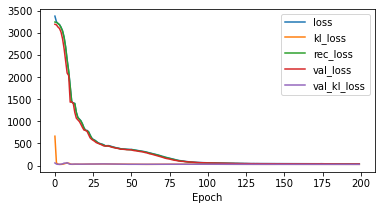

In [149]:
## Trenowanie dla danych syntetycznych

dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')



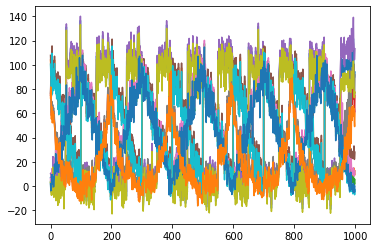

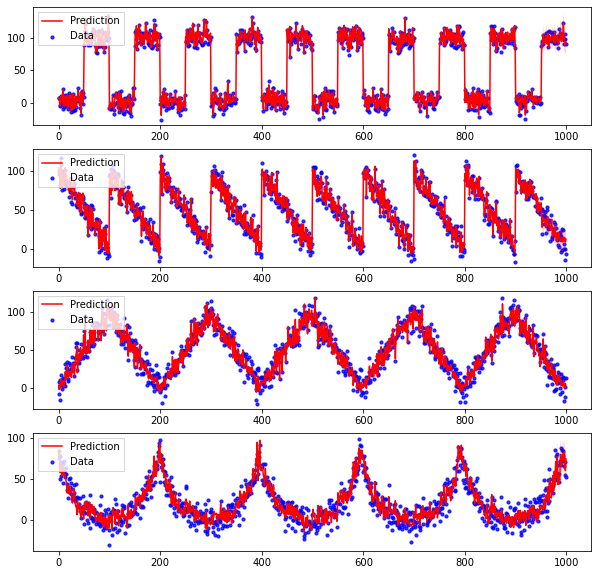

In [150]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 50)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

#################################################################################

In [151]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  39.025108    0.94911  4.363547
\begin{tabular}{lrrr}
\toprule
{} &        MSE &  R-squared &       MAE \\
\midrule
Average &  39.025108 &    0.94911 &  4.363547 \\
\bottomrule
\end{tabular}

               MSE  R-squared       MAE
sample1  19.623789   0.992260  2.606369
sample2  19.364271   0.978687  3.185898
sample3  39.309170   0.957319  4.687184
sample4  77.803207   0.868172  6.974738


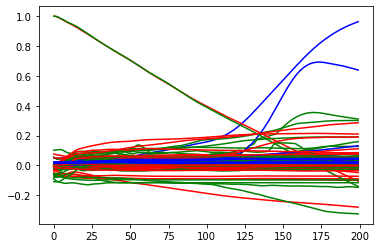

In [188]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

## Haversine distance

In [141]:

def workout_to_haversine(i):
    ###Calculates haversine distance from point [0,0] in radians for a workout
    ###sklearn wants [lat,long] in radians
    ### to get distance in kilometers multiply by 6371000/1000 
    lat = np.asarray(data_endo[i]['latitude'])
    lon = np.asarray(data_endo[i]['longitude'])
    coords = np.column_stack([lat, lon])    
    coords_in_radians = np.radians(coords)
    zeros = np.zeros_like(coords_in_radians)
    zeros = np.radians(zeros)
    result = haversine_distances(coords_in_radians, zeros)
    result = result
    return result[:,0]


In [142]:

data = np.vstack( [workout_to_haversine(i) for i in range(5)]).T
#print(data.shape)
#print(data)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)


Epoch= 1/200, loss= 4.893, mse= 4.039, kld= 4.271
	val_loss= 4.594, val_mse= 3.983, val_kld= 3.058
Epoch= 11/200, loss= 2.711, mse= 2.592, kld= 0.593
	val_loss= 2.588, val_mse= 2.478, val_kld= 0.550
Epoch= 21/200, loss= 2.293, mse= 2.244, kld= 0.245
	val_loss= 2.292, val_mse= 2.243, val_kld= 0.246
Epoch= 31/200, loss= 2.047, mse= 2.023, kld= 0.118
	val_loss= 1.971, val_mse= 1.948, val_kld= 0.111
Epoch= 41/200, loss= 1.949, mse= 1.935, kld= 0.070
	val_loss= 1.886, val_mse= 1.873, val_kld= 0.064
Epoch= 51/200, loss= 1.816, mse= 1.807, kld= 0.045
	val_loss= 1.571, val_mse= 1.562, val_kld= 0.043
Epoch= 61/200, loss= 1.598, mse= 1.592, kld= 0.032
	val_loss= 1.593, val_mse= 1.586, val_kld= 0.032
Epoch= 71/200, loss= 1.494, mse= 1.489, kld= 0.024
	val_loss= 1.511, val_mse= 1.506, val_kld= 0.025
Epoch= 81/200, loss= 1.343, mse= 1.339, kld= 0.019
	val_loss= 1.231, val_mse= 1.228, val_kld= 0.019
Epoch= 91/200, loss= 1.249, mse= 1.245, kld= 0.016
	val_loss= 1.381, val_mse= 1.379, val_kld= 0.013
E

<AxesSubplot:xlabel='Epoch'>

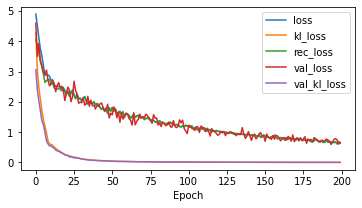

In [143]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

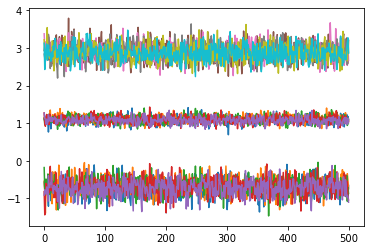

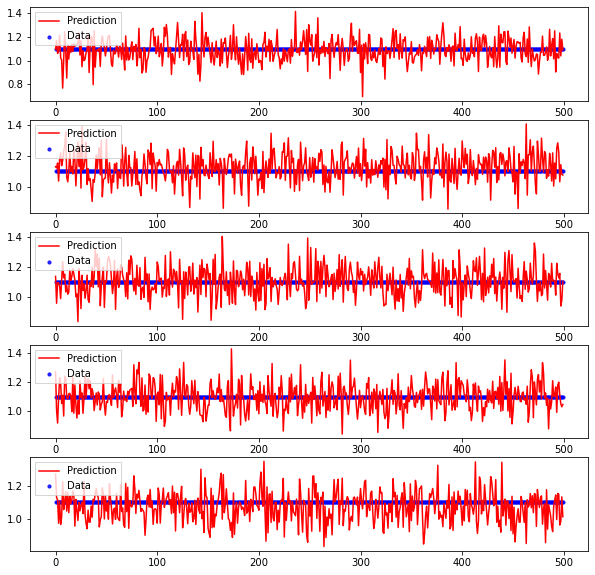

In [144]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [145]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

              MSE     R-squared       MAE
Average  0.009493 -84081.406163  0.077461
\begin{tabular}{lrrr}
\toprule
{} &       MSE &     R-squared &       MAE \\
\midrule
Average &  0.009493 & -84081.406163 &  0.077461 \\
\bottomrule
\end{tabular}

              MSE      R-squared       MAE
sample1  0.010314  -47355.756571  0.080224
sample2  0.009041  -89574.591480  0.075802
sample3  0.009795  -41252.873744  0.078983
sample4  0.009324  -93853.088264  0.077146
sample5  0.008989 -148370.720757  0.075152


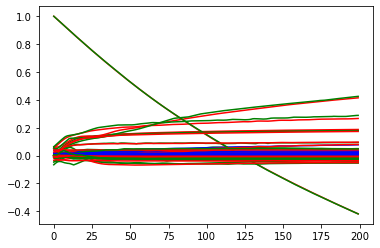

In [194]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

## Haversine distance normalised to [0,100] for every workout individually

In [133]:
data = np.vstack([NormalizeData(workout_to_haversine(i)) for i in range(5)]).T
#print(data.shape)

#print(data)

x = torch.FloatTensor(data).reshape(1, *data.shape)
print(x.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)



torch.Size([1, 500, 5])


In [136]:

dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)


Epoch= 1/200, loss= 4039.923, mse= 4035.046, kld= 48.771
	val_loss= 5999.735, val_mse= 5997.923, val_kld= 18.121
Epoch= 11/200, loss= 1608.003, mse= 1588.603, kld= 193.998
	val_loss= 977.404, val_mse= 961.288, val_kld= 161.156
Epoch= 21/200, loss= 714.506, mse= 711.245, kld= 32.601
	val_loss= 1050.194, val_mse= 1044.916, val_kld= 52.787
Epoch= 31/200, loss= 624.614, mse= 622.066, kld= 25.480
	val_loss= 729.232, val_mse= 725.188, val_kld= 40.441
Epoch= 41/200, loss= 589.652, mse= 587.528, kld= 21.243
	val_loss= 656.381, val_mse= 652.889, val_kld= 34.922
Epoch= 51/200, loss= 468.353, mse= 466.271, kld= 20.812
	val_loss= 545.451, val_mse= 542.012, val_kld= 34.389
Epoch= 61/200, loss= 193.659, mse= 191.015, kld= 26.444
	val_loss= 296.234, val_mse= 292.297, val_kld= 39.370
Epoch= 71/200, loss= 153.221, mse= 151.084, kld= 21.375
	val_loss= 236.158, val_mse= 232.788, val_kld= 33.695
Epoch= 81/200, loss= 131.037, mse= 128.977, kld= 20.605
	val_loss= 187.821, val_mse= 184.533, val_kld= 32.888
E

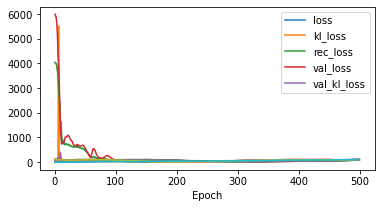

In [137]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)



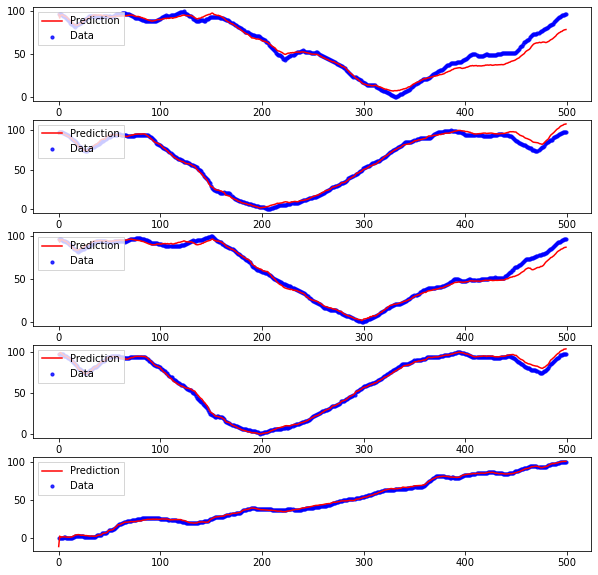

In [138]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [139]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  15.982272   0.983007  2.419631
\begin{tabular}{lrrr}
\toprule
{} &        MSE &  R-squared &       MAE \\
\midrule
Average &  15.982272 &   0.983007 &  2.419631 \\
\bottomrule
\end{tabular}

               MSE  R-squared       MAE
sample1  44.288731   0.950085  4.551568
sample2  10.980735   0.990139  2.226353
sample3  18.349506   0.980997  2.804388
sample4   4.598978   0.995823  1.518571
sample5   1.693412   0.997990  0.997271


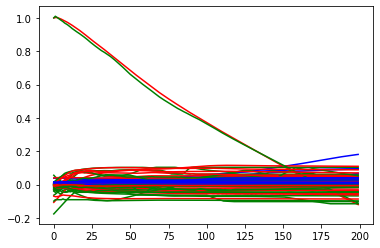

In [140]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

## Wodociągi Wrocławskie

In [120]:
#i = #examples
i = 7

In [121]:
df = pd.read_csv('water_consumption_profiles.csv')

In [122]:
_ = df.values

In [123]:
all_days = _[:,1:].T

In [124]:
all_days.shape

(144, 651)

In [125]:
all_days = all_days.astype('float64')

In [126]:
data = all_days[:, :7]

In [127]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:100]).reshape(1, 100, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[100:120]).reshape(1, 20, data.shape[1])
#print(x_val)



Epoch= 1/200, loss= 878.573, mse= 846.132, kld= 324.404
	val_loss= 1118.364, val_mse= 1115.171, val_kld= 31.925
Epoch= 11/200, loss= 97.885, mse= 93.423, kld= 44.624
	val_loss= 131.043, val_mse= 124.989, val_kld= 60.544
Epoch= 21/200, loss= 63.036, mse= 59.511, kld= 35.245
	val_loss= 54.165, val_mse= 49.089, val_kld= 50.756
Epoch= 31/200, loss= 51.367, mse= 48.635, kld= 27.314
	val_loss= 24.231, val_mse= 20.102, val_kld= 41.289
Epoch= 41/200, loss= 43.342, mse= 41.249, kld= 20.936
	val_loss= 22.881, val_mse= 19.505, val_kld= 33.760
Epoch= 51/200, loss= 41.223, mse= 39.565, kld= 16.577
	val_loss= 20.391, val_mse= 17.736, val_kld= 26.558
Epoch= 61/200, loss= 39.032, mse= 37.670, kld= 13.618
	val_loss= 18.146, val_mse= 16.119, val_kld= 20.266
Epoch= 71/200, loss= 38.750, mse= 37.612, kld= 11.378
	val_loss= 16.954, val_mse= 15.298, val_kld= 16.556
Epoch= 81/200, loss= 36.762, mse= 35.734, kld= 10.280
	val_loss= 16.853, val_mse= 15.225, val_kld= 16.277
Epoch= 91/200, loss= 35.243, mse= 34.1

<AxesSubplot:xlabel='Epoch'>

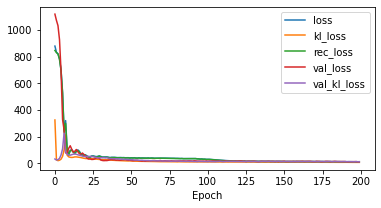

In [128]:

dkf = DKF(input_dim=i, z_dim=5*i, rnn_dim=5*i, trans_dim=5*i, emission_dim=5*i)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

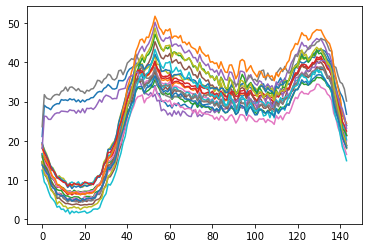

In [129]:

# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 50)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)


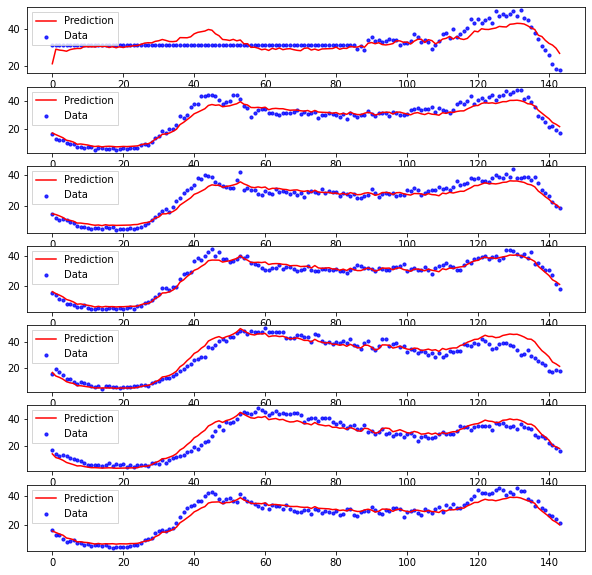

In [130]:
fig, ax = plt.subplots(i, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [131]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)


               MSE  R-squared       MAE
Average  12.763991    0.86544  2.763783
\begin{tabular}{lrrr}
\toprule
{} &        MSE &  R-squared &       MAE \\
\midrule
Average &  12.763991 &    0.86544 &  2.763783 \\
\bottomrule
\end{tabular}

               MSE  R-squared       MAE
sample1  14.656689   0.540190  2.964566
sample2  13.389262   0.915392  2.927640
sample3  10.855779   0.907706  2.622897
sample4   5.671514   0.959214  1.893803
sample5  20.256552   0.895415  3.291651
sample6  15.130086   0.910221  3.237197
sample7   9.388056   0.929944  2.408721


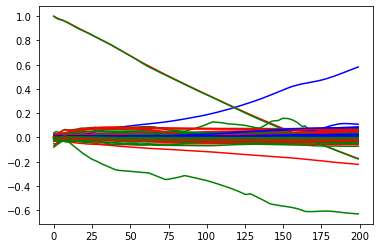

In [223]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

# Sample-Normalized Deep Kalman Filter

In [66]:
def NormalizeByRow(data):
    
    data = data.numpy()
    
    # Reshape the data into a 2-dimensional array (500 rows, 5 columns)
    reshaped_data = data.reshape(data.shape[1], data.shape[2])

    # Calculate the minimum and maximum values for each column
    min_values = np.min(reshaped_data, axis=0)
    max_values = np.max(reshaped_data, axis=0)

    # Normalize each column to the range 0 to 100
    normalized_data = ((reshaped_data - min_values) / (max_values - min_values)) * 100

    # Reshape the normalized data back to the original shape
    normalized_data = normalized_data.reshape(1, data.shape[1], data.shape[2])
    normalized_data = torch.FloatTensor(normalized_data)

    return(normalized_data)

def DenormalizeByRow(normalized_data, original_min, original_max):
    # Convert the PyTorch tensor to a NumPy array
    normalized_data = normalized_data.numpy()
    
    # Reshape the normalized data into a 2-dimensional array (number_of_samples, number_of_features)
    reshaped_data = normalized_data.reshape(normalized_data.shape[1], normalized_data.shape[2])

    # Calculate the denormalized data using the original range
    denormalized_data = original_min + (reshaped_data / 100) * (original_max - original_min)

    # Reshape the denormalized data back to the original shape
    denormalized_data = denormalized_data.reshape(1, normalized_data.shape[1], normalized_data.shape[2])
    
    # Convert the denormalized NumPy array back to a PyTorch tensor
    denormalized_data = torch.FloatTensor(denormalized_data)

    return denormalized_data



#max_values, _ = torch.max(matrix, dim=1)
#min_values, _ = torch.min(matrix, dim=1)

#max_values = max_values.numpy()
#min_values = min_values.numpy()

In [67]:
data = np.vstack([np.asarray(data_endo[0]['altitude']), np.asarray(data_endo[1]['altitude']), 
                  np.asarray(data_endo[2]['altitude']), np.asarray(data_endo[3]['altitude']),
                  np.asarray(data_endo[4]['altitude'])]).T

x = torch.FloatTensor(data).reshape(1, *data.shape)

print(x)

y = NormalizeByRow(x)

print(y)
y = y.numpy()
print(np.max(y, axis = 1))
print(np.min(y, axis = 1))

tensor([[[41.6000, 38.4000, 76.4000, 28.6000, 32.0000],
         [40.6000, 39.0000, 73.2000, 29.4000, 32.0000],
         [40.6000, 39.0000, 72.4000, 29.4000, 32.0000],
         ...,
         [31.8000, 34.2000, 50.2000, 29.8000, 14.4000],
         [34.4000, 35.0000, 52.8000, 30.8000, 15.0000],
         [36.2000, 35.0000, 52.8000, 32.8000, 14.2000]]])
tensor([[[45.3020, 41.8972, 70.9571, 31.3954, 79.2857],
         [43.6242, 43.0830, 65.6766, 32.9457, 79.2857],
         [43.6242, 43.0830, 64.3564, 32.9457, 79.2857],
         ...,
         [28.8591, 33.5968, 27.7228, 33.7209, 16.4286],
         [33.2215, 35.1779, 32.0132, 35.6589, 18.5714],
         [36.2416, 35.1779, 32.0132, 39.5349, 15.7143]]])
[[100. 100. 100. 100. 100.]]
[[0. 0. 0. 0. 0.]]


In [68]:
class GatedTransition(nn.Module):
    def __init__(self, z_dim, hid_dim):
        super(GatedTransition, self).__init__()
        self.gate = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim),
            nn.Sigmoid())
        self.proposed_mean = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim))
        self.z_to_mu = nn.Linear(z_dim, z_dim)
        # modify the default initialization of z_to_mu
        # so that it starts out as the identity function
        self.z_to_mu.weight.data = torch.eye(z_dim)
        self.z_to_mu.bias.data = torch.zeros(z_dim)
        self.z_to_logvar = nn.Linear(z_dim, z_dim)
        self.relu = nn.ReLU()
        
    def forward(self, z_t_1):
        #
        gate = self.gate(z_t_1)
        proposed_mean = self.proposed_mean(z_t_1)
        mu = (1 - gate) * self.z_to_mu(z_t_1) + gate * proposed_mean
        logvar = self.z_to_logvar(self.relu(proposed_mean))
        # sampling
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [69]:
class Combiner(nn.Module):
    # PostNet
    def __init__(self, z_dim, hid_dim):
        super(Combiner, self).__init__()
        self.z_dim = z_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_mu = nn.Linear(hid_dim, z_dim)
        self.hidden_to_logvar = nn.Linear(hid_dim, z_dim)
        self.tanh = nn.Tanh()
    def forward(self, z_t_1, h_rnn):
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state
        # to compute the mean used to sample z_t
        mu = self.hidden_to_mu(h_combined)
        # use the combined hidden state
        # to compute the scale used to sample z_t
        logvar = self.hidden_to_logvar(h_combined)
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [70]:
class Emitter(nn.Module):
    def __init__(self, z_dim, hid_dim, input_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_hidden = nn.Linear(hid_dim, hid_dim)
        self.hidden_to_input_mu = nn.Linear(hid_dim, input_dim)
        self.logvar = nn.Parameter(torch.ones(input_dim))
        self.relu = nn.ReLU()
    def forward(self, z_t):
        h1 = self.relu(self.z_to_hidden(z_t))
        h2 = self.relu(self.hidden_to_hidden(h1))
        mu = self.hidden_to_input_mu(h2)
        # return mu # x_t
        eps = torch.randn(z_t.size(0), self.input_dim)
        x_t = mu + eps * torch.exp(.5 * self.logvar)
        return x_t, mu, self.logvar

In [71]:
class RNDKF(nn.Module):
    # Structured Inference Networks
    # Current version ignores backward RNN outputs
    def __init__(self, input_dim, z_dim=50, trans_dim=30, emission_dim=30,
            rnn_dim=100, num_rnn_layers=1) -> None:
        
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.trans_dim = trans_dim
        self.emission_dim = emission_dim
        self.rnn_dim = rnn_dim
        self.num_rnn_layers = num_rnn_layers
        self.trans = GatedTransition(z_dim, trans_dim)
        self.emitter = Emitter(z_dim, emission_dim, input_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))
        # corresponding learning 'l' in the original code
        self.rnn = nn.RNN(input_size=input_dim,
            hidden_size=rnn_dim,
            nonlinearity="relu",
            batch_first=True,
            bidirectional=False,
            num_layers=num_rnn_layers)
        
    def kl_div(self, mu1, logvar1, mu2=None, logvar2=None):
        if mu2 is None:
            mu2 = torch.zeros(1, device=mu1.device)
        if logvar2 is None:
            logvar2 = torch.zeros(1, device=mu1.device)
        return torch.sum(0.5 * (
            logvar2 - logvar1 + (torch.exp(logvar1) + (mu1 - mu2).pow(2))
            / torch.exp(logvar2) - torch.ones(1, device=mu1.device)
        ), 1)

    def infer(self, x):
        batch_size, T_max, x_dim = x.size()
        h_0 = self.h_0.expand(1, batch_size, self.rnn_dim).contiguous()
        rnn_out, h_n = self.rnn(x, h_0)
        z_prev = self.z_q_0.expand(batch_size, self.z_q_0.size(0))
        kl_states = torch.zeros((batch_size, T_max))
        rec_losses = torch.zeros((batch_size, T_max))
        for t in range(T_max):
            # p(z_t|z_{t-1})
            z_prior, z_prior_mu, z_prior_logvar = self.trans(z_prev)
            # q(z_t|z_{t-1},x_{t:T})
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            # p(x_t|z_t)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # compute loss
            kl_states[:, t] = self.kl_div(
                z_mu, z_logvar, z_prior_mu, z_prior_logvar)
            rec_losses[:, t] = nn.MSELoss(reduction='none')(
                x_t.contiguous().view(-1),
                # x_mu.contiguous().view(-1),
                x[:, t].contiguous().view(-1)
            ).view(batch_size, -1).mean(dim=1)
            z_prev = z_t
        return rec_losses.mean(), kl_states.mean()
    
    def filter(self, x, num_sample=100):
        # Outputs
        x_hat = torch.zeros(x.size())
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        # predictions
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x, h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # x_hat[:, t] = x_mu
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            # # sampling z_t and computing quantiles
            # x_samples = MultivariateNormal(
            #   loc=x_mu, covariance_matrix=x_covar).sample_n(num_sample)
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            # x_hat[:, t] = x_t.mean(0)
            # x_025[:, t] = x_t.quantile(0.025, 0)
            # x_975[:, t] = x_t.quantile(0.975, 0)
            z_prev = z_t
            # z_prev = z_mu
        return x_hat, x_025, x_975
    
    def predict(self, x, pred_steps=1, num_sample=100):
        """ x should contain the prediction period
        """
        # Outputs
                    
        max_x, _ = torch.max(x, dim=1)
        min_x, _ = torch.min(x, dim=1)
        
        max_x = max_x.numpy()
        min_x = min_x.numpy()
        
        print(max_x)
        print(min_x)
        
        x = NormalizeByRow(x)
        
        x_hat = torch.zeros(x.size()) # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x[:, :T_max-pred_steps], h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max - pred_steps):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            z_prev = z_mu
        for t in range(T_max - pred_steps, T_max):
            rnn_out, _ = self.rnn(x[:, :t], h_0)
            rnn_out = rnn_out.expand(
                num_sample, rnn_out.size(1), rnn_out.size(2))
            z_t_1, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, -1])
            z_t, z_mu, z_logvar = self.trans(z_t_1)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            
        
        x_hat = DenormalizeByRow(x_hat, min_x, max_x)
        
        x_025 = DenormalizeByRow(x_025, min_x, max_x)
        
        x_975 = DenormalizeByRow(x_975, min_x, max_x)
            
            
        return x_hat, x_025, x_975
    
    def train_step(self, x, annealing_factor = 0.1):
        self.train()
        # self.rnn.train()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        self.optimizer.zero_grad()
        total_loss.backward()
        # nn.utils.clip_grad_norm_(self.parameters(), 5.)
        self.optimizer.step()
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def validation_step(self, x, annealing_factor=0.1):
        self.eval()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def fit(self, x, x_val=None, num_epochs=100, annealing_factor=0.1,
            verbose_step=1, eval_step=1, check_point_path=None,
            patience=20, learning_rate=0.01):
        
        #print(x)
        #print(x_val)
        #print(x.shape)
        #print(x_val.shape)
        
        concat_x = torch.cat((x, x_val), dim = 1)
        
        concat_x = NormalizeByRow(concat_x)
        
        x = concat_x[:, :x.shape[1], :]
        x_val = concat_x[:, x.shape[1]:, :]
        
        
        #x = NormalizeByRow(x)
        
        #x_val = NormalizeByRow(x_val)
        
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate)
        
        losses = []
        kl_losses = []
        rec_losses = []
        val_losses = []
        val_kl_losses = []
        val_rec_losses = []
        parameter_values = []

        
        stats_dict = {}
        
        for index, param in enumerate(self.parameters()):
            stats_dict['mean_var_median' + str(index)] = []
            
                        
            
        
        
        for epoch in range(num_epochs):
            for index, param in enumerate(self.parameters()):
                param_value = param.detach().numpy()
                stats_dict['mean_var_median' + str(index)].append([np.mean(param_value), np.var(param_value), np.median(param_value)])                      

            try:
                res = self.train_step(x, annealing_factor=annealing_factor)
                losses.append(res[2])
                kl_losses.append(res[1])
                rec_losses.append(res[0])  
                
                if epoch % verbose_step == verbose_step - 1:
                    message = f'Epoch= {epoch+1}/{num_epochs}, '
                    message += f'loss= {res[2]:.3f}, '
                    message += f'mse= {res[0]:.3f}, '
                    message += f'kld= {res[1]:.3f}'
                    if (epoch % 10 == 0):
                        print(message)
                    
                if x_val is not None:
                    val_res = self.validation_step(x_val, annealing_factor)
                    val_losses.append(val_res[2])
                    val_kl_losses.append(val_res[1])
                    val_rec_losses.append(val_res[0])  
                    
                if epoch % eval_step == eval_step - 1 and x_val is not None:
                    message = f'\tval_loss= {val_res[2]:.3f}, '
                    message += f'val_mse= {val_res[0]:.3f}, '
                    message += f'val_kld= {val_res[1]:.3f}'
                    if (epoch % 10 == 0):
                        print(message)
                    
            except KeyboardInterrupt:
                break                    
                
        history = {'loss': losses,
                   'kl_loss': kl_losses,
                   'rec_loss': rec_losses}
        
        if x_val is not None:
            history.update({'val_loss': val_losses,
                            'val_kl_loss': val_kl_losses,
                            'rec_loss': rec_losses})
            
            
        return history, stats_dict
            
    def save_model(self, filename):
        """ dkf.pth """
        torch.save(self.to('cpu').state_dict(), filename)       
        
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        
    def get_config(self):
        return {
            'input_dim': self.input_dim,
            'z_dim': self.z_dim,
            'trans_dim': self.trans_dim,
            'emission_dim': self.emission_dim,
            'rnn_dim': self.rnn_dim,
            'num_rnn_layers': self.num_rnn_layers
        }

In [72]:
data = np.vstack([NormalizeData(workout_to_haversine(i)) for i in range(5)]).T
#print(data.shape)

#print(data)

x = torch.FloatTensor(data).reshape(1, *data.shape)
print(x.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)




torch.Size([1, 500, 5])


In [73]:
# Create a 4 by 3 numpy array
array = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9],
                  [10, 11, 12]])

# Find the maximum value in each row along axis 1 (rows)
max_values = np.max(array, axis=1)

print(max_values)
x_array = x.numpy()
print(x_array.shape)
print(np.max(x_array, axis = 1))
print(np.min(x_array, axis = 1))
print(list(x_array.shape[i] for i in range(len(x_array.shape))))
print(x_array.shape[0])

[ 3  6  9 12]
(1, 500, 5)
[[100. 100. 100. 100. 100.]]
[[0. 0. 0. 0. 0.]]
[1, 500, 5]
1


In [74]:
data = np.vstack([np.asarray(data_endo[0]['altitude']), np.asarray(data_endo[1]['altitude']), 
                  np.asarray(data_endo[2]['altitude']), np.asarray(data_endo[3]['altitude']),
                  np.asarray(data_endo[4]['altitude'])]).T

x = torch.FloatTensor(data).reshape(1, *data.shape)

print(x)
x_array = x.numpy()
print(np.max(x_array, axis = 1))
print(np.min(x_array, axis = 1))

tensor([[[41.6000, 38.4000, 76.4000, 28.6000, 32.0000],
         [40.6000, 39.0000, 73.2000, 29.4000, 32.0000],
         [40.6000, 39.0000, 72.4000, 29.4000, 32.0000],
         ...,
         [31.8000, 34.2000, 50.2000, 29.8000, 14.4000],
         [34.4000, 35.0000, 52.8000, 30.8000, 15.0000],
         [36.2000, 35.0000, 52.8000, 32.8000, 14.2000]]])
[[74.2 67.8 94.  64.  37.8]]
[[14.6 17.2 33.4 12.4  9.8]]


In [75]:


# Create a 500 by 5 matrix (replace this with your actual data)
data = np.random.rand(500, 5)

print(data)

# Calculate the minimum and maximum values for each column
min_values = np.min(data, axis=0)
max_values = np.max(data, axis=0)

# Normalize each column to the range 0 to 100
normalized_data = ((data - min_values) / (max_values - min_values)) * 100

print(normalized_data)
print(np.max(normalized_data, axis = 0))
print(np.min(normalized_data, axis = 0))

[[0.40824829 0.42047711 0.84652862 0.29860048 0.85323707]
 [0.94670401 0.19699744 0.04570914 0.21204801 0.52049348]
 [0.09232267 0.27158209 0.84251467 0.11220786 0.49554251]
 ...
 [0.86058844 0.84490207 0.31249132 0.16193514 0.35341034]
 [0.71813896 0.38097885 0.01730163 0.93446313 0.17092126]
 [0.36367215 0.14784305 0.91131964 0.72575639 0.89654351]]
[[40.73891066 41.95745005 85.03023417 29.7647517  85.41012127]
 [94.67009951 19.53153255  4.57779151 21.08167829 52.09363649]
 [ 9.09611558 27.01601282 84.6269822  11.06556495 49.59538008]
 ...
 [86.04484993 84.54798639 31.37943509 16.05428029 35.36416885]
 [71.77725119 37.99384717  1.72389755 93.55544549 17.09215805]
 [36.27420903 14.59894921 91.53931139 72.61767256 89.74624781]]
[100. 100. 100. 100. 100.]
[0. 0. 0. 0. 0.]


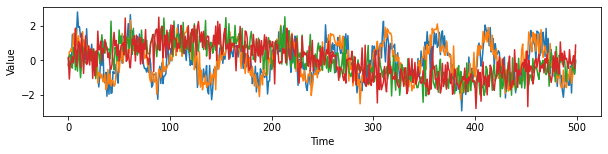

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [77]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [78]:
dkf = RNDKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

In [79]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 3228.999, mse= 3148.204, kld= 807.947
	val_loss= 2003.484, val_mse= 1996.513, val_kld= 69.717
Epoch= 11/200, loss= 799.942, mse= 786.890, kld= 130.515
	val_loss= 1026.859, val_mse= 1020.787, val_kld= 60.728
Epoch= 21/200, loss= 287.778, mse= 283.221, kld= 45.566
	val_loss= 209.032, val_mse= 204.942, val_kld= 40.902
Epoch= 31/200, loss= 249.345, mse= 245.305, kld= 40.401
	val_loss= 280.484, val_mse= 276.803, val_kld= 36.812
Epoch= 41/200, loss= 238.156, mse= 234.666, kld= 34.904
	val_loss= 325.871, val_mse= 322.603, val_kld= 32.679
Epoch= 51/200, loss= 226.467, mse= 223.395, kld= 30.719
	val_loss= 288.847, val_mse= 285.880, val_kld= 29.678
Epoch= 61/200, loss= 219.077, mse= 216.304, kld= 27.731
	val_loss= 272.632, val_mse= 269.952, val_kld= 26.803
Epoch= 71/200, loss= 214.786, mse= 212.196, kld= 25.899
	val_loss= 279.685, val_mse= 277.141, val_kld= 25.442
Epoch= 81/200, loss= 214.281, mse= 211.700, kld= 25.809
	val_loss= 281.913, val_mse= 279.361, val_kld= 25.519
Epo

<AxesSubplot:xlabel='Epoch'>

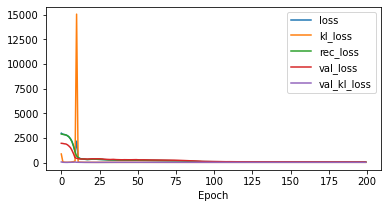

In [116]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

[[2.4821298 2.4622803 2.7782953 2.8465219]]
[[-2.2869356 -2.314187  -2.450089  -2.982882 ]]
torch.Size([1, 500, 4])
torch.Size([1, 500, 4])
torch.Size([1, 500, 4])


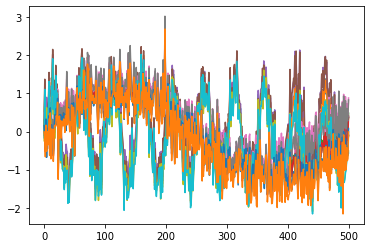

In [117]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

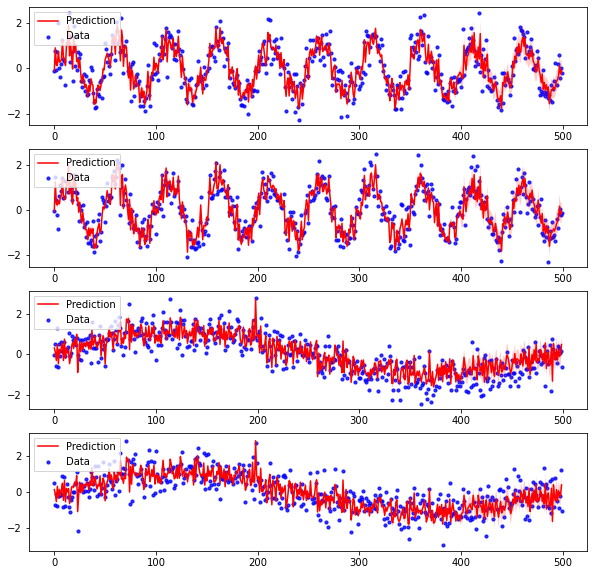

In [118]:
fig, ax = plt.subplots(4, figsize=(10, 10))


#data = NormalizeData(data)

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

## 5 first workouts - Haversine distance

In [115]:

def workout_to_haversine(i):
    ###Calculates haversine distance from point [0,0] in radians for a workout
    ###sklearn wants [lat,long] in radians
    ### to get distance in kilometers multiply by 6371000/1000 
    lat = np.asarray(data_endo[i]['latitude'])
    lon = np.asarray(data_endo[i]['longitude'])
    coords = np.column_stack([lat, lon])    
    coords_in_radians = np.radians(coords)
    zeros = np.zeros_like(coords_in_radians)
    zeros = np.radians(zeros)
    result = haversine_distances(coords_in_radians, zeros)
    result = result
    return result[:,0]


In [116]:

data = np.vstack( [workout_to_haversine(i) for i in range(5)]).T
#print(data.shape)
#print(data)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)


Epoch= 1/200, loss= 4694.212, mse= 4136.792, kld= 2787.099
	val_loss= 6366.399, val_mse= 6349.545, val_kld= 84.270
Epoch= 11/200, loss= 1664.079, mse= 1621.826, kld= 211.264
	val_loss= 3048.927, val_mse= 2796.760, val_kld= 1260.831
Epoch= 21/200, loss= 715.236, mse= 702.034, kld= 66.010
	val_loss= 1303.083, val_mse= 1286.934, val_kld= 80.747
Epoch= 31/200, loss= 593.635, mse= 584.270, kld= 46.825
	val_loss= 782.795, val_mse= 769.629, val_kld= 65.829
Epoch= 41/200, loss= 253.748, mse= 244.993, kld= 43.774
	val_loss= 214.785, val_mse= 201.094, val_kld= 68.456
Epoch= 51/200, loss= 139.739, mse= 131.436, kld= 41.516
	val_loss= 125.404, val_mse= 113.319, val_kld= 60.424
Epoch= 61/200, loss= 43.563, mse= 35.534, kld= 40.144
	val_loss= 104.561, val_mse= 93.472, val_kld= 55.442
Epoch= 71/200, loss= 36.693, mse= 29.996, kld= 33.485
	val_loss= 77.423, val_mse= 67.687, val_kld= 48.681
Epoch= 81/200, loss= 28.851, mse= 23.471, kld= 26.904
	val_loss= 67.480, val_mse= 59.427, val_kld= 40.267
Epoch= 

<AxesSubplot:xlabel='Epoch'>

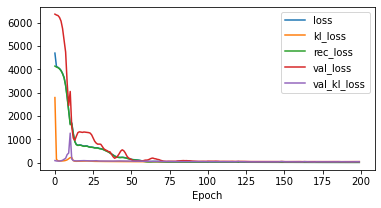

In [117]:
dkf = RNDKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

[[1.1017815 1.1017488 1.1017824 1.1017468 1.1025736]]
[[1.1002148 1.1007968 1.1002144 1.1007969 1.1017256]]


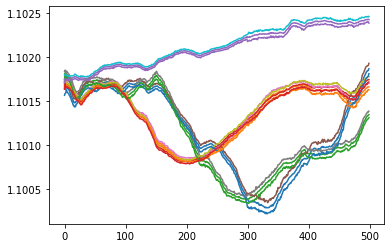

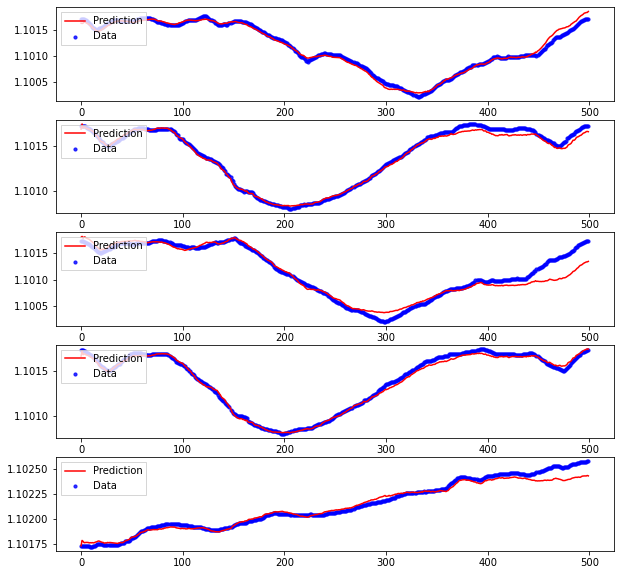

In [118]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)



x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)



fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [119]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

                  MSE  R-squared       MAE
Average  5.082199e-09   0.970426  0.000042
\begin{tabular}{lrrr}
\toprule
{} &           MSE &  R-squared &       MAE \\
\midrule
Average &  5.082199e-09 &   0.970426 &  0.000042 \\
\bottomrule
\end{tabular}

                  MSE  R-squared       MAE
sample1  2.510496e-09   0.988473  0.000040
sample2  1.161798e-09   0.988489  0.000025
sample3  1.859503e-08   0.921686  0.000086
sample4  8.337564e-10   0.991607  0.000023
sample5  2.309913e-09   0.961873  0.000034


## Wodociągi SNDKF

Epoch= 1/200, loss= 4655.054, mse= 3023.830, kld= 16312.235
	val_loss= 4409.306, val_mse= 4398.054, val_kld= 112.526
Epoch= 11/200, loss= 641.350, mse= 633.896, kld= 74.539
	val_loss= 481.601, val_mse= 469.861, val_kld= 117.400
Epoch= 21/200, loss= 242.212, mse= 235.111, kld= 71.012
	val_loss= 510.953, val_mse= 501.128, val_kld= 98.251
Epoch= 31/200, loss= 124.171, mse= 118.496, kld= 56.750
	val_loss= 242.619, val_mse= 234.383, val_kld= 82.362
Epoch= 41/200, loss= 108.744, mse= 104.049, kld= 46.948
	val_loss= 256.397, val_mse= 249.218, val_kld= 71.790
Epoch= 51/200, loss= 91.493, mse= 87.484, kld= 40.086
	val_loss= 394.584, val_mse= 387.548, val_kld= 70.366
Epoch= 61/200, loss= 85.700, mse= 82.189, kld= 35.109
	val_loss= 273.003, val_mse= 266.691, val_kld= 63.113
Epoch= 71/200, loss= 79.654, mse= 76.577, kld= 30.770
	val_loss= 272.785, val_mse= 266.976, val_kld= 58.091
Epoch= 81/200, loss= 63.203, mse= 60.449, kld= 27.544
	val_loss= 251.699, val_mse= 246.165, val_kld= 55.344
Epoch= 91/

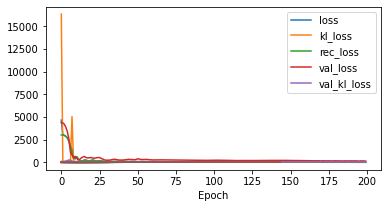

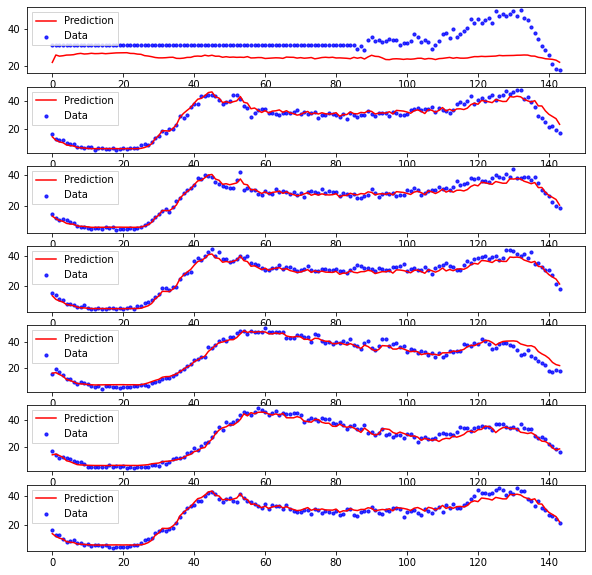

               MSE  R-squared       MAE
Average  20.241703   0.490899  2.818185
\begin{tabular}{lrrr}
\toprule
{} &        MSE &  R-squared &       MAE \\
\midrule
Average &  20.241703 &   0.490899 &  2.818185 \\
\bottomrule
\end{tabular}

                MSE  R-squared       MAE
sample1  106.136581  -2.329718  8.870435
sample2    8.380854   0.947040  2.056174
sample3    4.576794   0.961089  1.642214
sample4    5.222277   0.962445  1.801579
sample5    7.662706   0.960437  1.921162
sample6    4.892644   0.970968  1.781219
sample7    4.820065   0.964032  1.654513


In [132]:
#i = #examples
i = 7

df = pd.read_csv('water_consumption_profiles.csv')

_ = df.values

all_days = _[:,1:].T

all_days.shape

all_days = all_days.astype('float64')

data = all_days[:, :7]



x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:100]).reshape(1, 100, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[100:120]).reshape(1, 20, data.shape[1])
#print(x_val)






dkf = RNDKF(input_dim=i, z_dim=5*i, rnn_dim=5*i, trans_dim=5*i, emission_dim=5*i)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')


# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 50)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)


fig, ax = plt.subplots(i, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()


mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)


## 5 first workouts by altitude SNDKF

Epoch= 1/200, loss= 2723.513, mse= 2693.369, kld= 301.441
	val_loss= 408.765, val_mse= 407.908, val_kld= 8.569
Epoch= 11/200, loss= 799.274, mse= 793.824, kld= 54.506
	val_loss= 154.641, val_mse= 152.629, val_kld= 20.114
Epoch= 21/200, loss= 389.146, mse= 385.581, kld= 35.648
	val_loss= 121.026, val_mse= 119.429, val_kld= 15.972
Epoch= 31/200, loss= 388.856, mse= 386.165, kld= 26.912
	val_loss= 79.614, val_mse= 78.422, val_kld= 11.914
Epoch= 41/200, loss= 344.266, mse= 341.976, kld= 22.893
	val_loss= 90.439, val_mse= 89.324, val_kld= 11.156
Epoch= 51/200, loss= 338.051, mse= 336.000, kld= 20.508
	val_loss= 100.097, val_mse= 99.021, val_kld= 10.759
Epoch= 61/200, loss= 326.234, mse= 324.287, kld= 19.472
	val_loss= 86.879, val_mse= 85.880, val_kld= 9.990
Epoch= 71/200, loss= 316.112, mse= 314.380, kld= 17.323
	val_loss= 87.070, val_mse= 86.135, val_kld= 9.344
Epoch= 81/200, loss= 294.454, mse= 292.847, kld= 16.063
	val_loss= 72.138, val_mse= 71.231, val_kld= 9.067
Epoch= 91/200, loss= 24

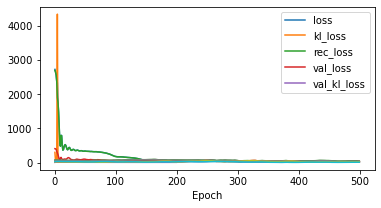

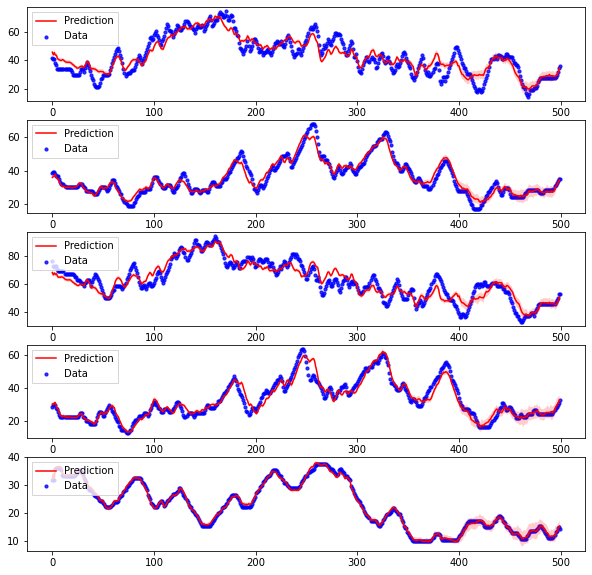

               MSE  R-squared       MAE
Average  14.341215   0.909761  2.674136
\begin{tabular}{lrrr}
\toprule
{} &        MSE &  R-squared &       MAE \\
\midrule
Average &  14.341215 &   0.909761 &  2.674136 \\
\bottomrule
\end{tabular}

               MSE  R-squared       MAE
sample1  27.780512   0.847023  4.325167
sample2   6.863517   0.936250  2.031850
sample3  26.590235   0.847797  4.186553
sample4  10.176459   0.921935  2.378122
sample5   0.295355   0.995798  0.448986


In [268]:
data = np.vstack([np.asarray(data_endo[0]['altitude']), np.asarray(data_endo[1]['altitude']), 
                  np.asarray(data_endo[2]['altitude']), np.asarray(data_endo[3]['altitude']),
                  np.asarray(data_endo[4]['altitude'])]).T
#print(data.shape)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:450]).reshape(1, 450, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[450:500]).reshape(1, 50, data.shape[1])
#print(x_val)

dkf = RNDKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()


mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

## First workout by longitude, latitude, altitude

Epoch= 1/200, loss= 2951.601, mse= 2921.725, kld= 298.761
	val_loss= 3207.267, val_mse= 3204.002, val_kld= 32.655
Epoch= 11/200, loss= 1071.227, mse= 1061.088, kld= 101.385
	val_loss= 1114.566, val_mse= 1105.598, val_kld= 89.677
Epoch= 21/200, loss= 523.381, mse= 520.686, kld= 26.950
	val_loss= 1617.276, val_mse= 1613.743, val_kld= 35.335
Epoch= 31/200, loss= 472.351, mse= 469.887, kld= 24.642
	val_loss= 1532.498, val_mse= 1529.975, val_kld= 25.225
Epoch= 41/200, loss= 456.174, mse= 453.915, kld= 22.593
	val_loss= 1527.359, val_mse= 1524.971, val_kld= 23.872
Epoch= 51/200, loss= 416.598, mse= 414.737, kld= 18.608
	val_loss= 1359.316, val_mse= 1357.078, val_kld= 22.379
Epoch= 61/200, loss= 261.473, mse= 259.832, kld= 16.409
	val_loss= 700.476, val_mse= 698.094, val_kld= 23.820
Epoch= 71/200, loss= 121.457, mse= 119.935, kld= 15.226
	val_loss= 119.790, val_mse= 117.304, val_kld= 24.857
Epoch= 81/200, loss= 86.217, mse= 84.854, kld= 13.629
	val_loss= 162.583, val_mse= 160.565, val_kld= 20

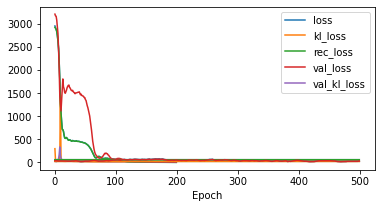

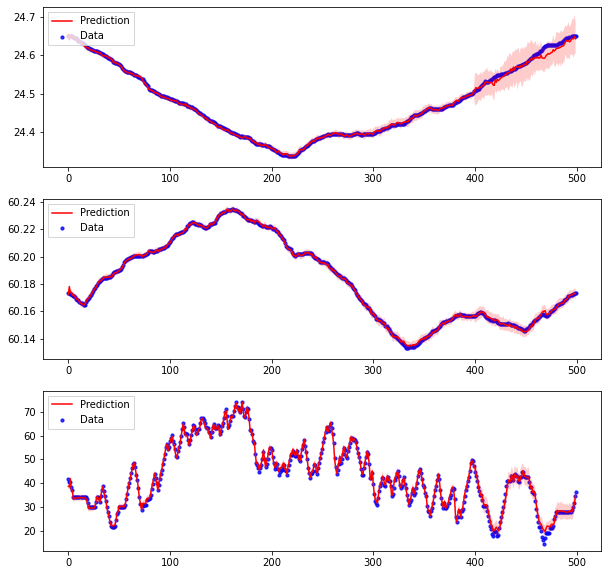

              MSE  R-squared       MAE
Average  0.292223   0.997089  0.204559
\begin{tabular}{lrrr}
\toprule
{} &       MSE &  R-squared &       MAE \\
\midrule
Average &  0.292223 &   0.997089 &  0.204559 \\
\bottomrule
\end{tabular}

                  MSE  R-squared       MAE
sample1  2.726945e-05   0.996773  0.002855
sample2  6.085288e-07   0.999321  0.000598
sample3  8.766397e-01   0.995173  0.610224


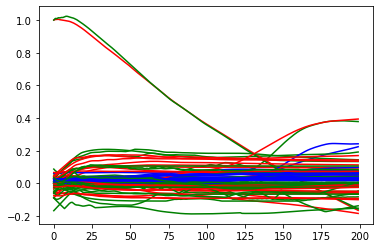

In [92]:
first_workout_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[0]['latitude']), np.asarray(data_endo[0]['altitude'])]).T
x = torch.FloatTensor(first_workout_data).reshape(1, *first_workout_data.shape)
#print(x)
x_train = torch.FloatTensor(first_workout_data[:450]).reshape(1, 450, first_workout_data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(first_workout_data[450:500]).reshape(1, 50, first_workout_data.shape[1])
#print(x_val)

dkf = RNDKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(first_workout_data.shape[0]),
        first_workout_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()


mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)


for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

## 3 first workouts by longitude

Epoch= 1/200, loss= 2386.466, mse= 2385.381, kld= 10.854
	val_loss= 8244.295, val_mse= 8242.546, val_kld= 17.492
Epoch= 11/200, loss= 923.343, mse= 921.547, kld= 17.959
	val_loss= 1769.701, val_mse= 1734.087, val_kld= 356.141
Epoch= 21/200, loss= 56.154, mse= 54.818, kld= 13.361
	val_loss= 156.611, val_mse= 153.323, val_kld= 32.876
Epoch= 31/200, loss= 42.777, mse= 41.634, kld= 11.425
	val_loss= 54.312, val_mse= 51.518, val_kld= 27.941
Epoch= 41/200, loss= 29.148, mse= 28.087, kld= 10.603
	val_loss= 30.190, val_mse= 27.517, val_kld= 26.723
Epoch= 51/200, loss= 24.237, mse= 23.251, kld= 9.852
	val_loss= 10.850, val_mse= 8.394, val_kld= 24.560
Epoch= 61/200, loss= 23.618, mse= 22.665, kld= 9.532
	val_loss= 11.397, val_mse= 8.759, val_kld= 26.381
Epoch= 71/200, loss= 22.133, mse= 21.189, kld= 9.436
	val_loss= 12.879, val_mse= 10.602, val_kld= 22.764
Epoch= 81/200, loss= 22.428, mse= 21.495, kld= 9.328
	val_loss= 10.884, val_mse= 8.108, val_kld= 27.764
Epoch= 91/200, loss= 21.950, mse= 21.

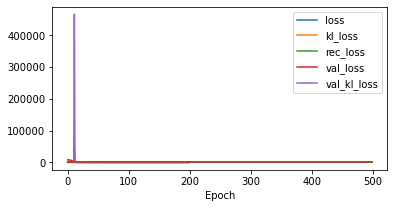

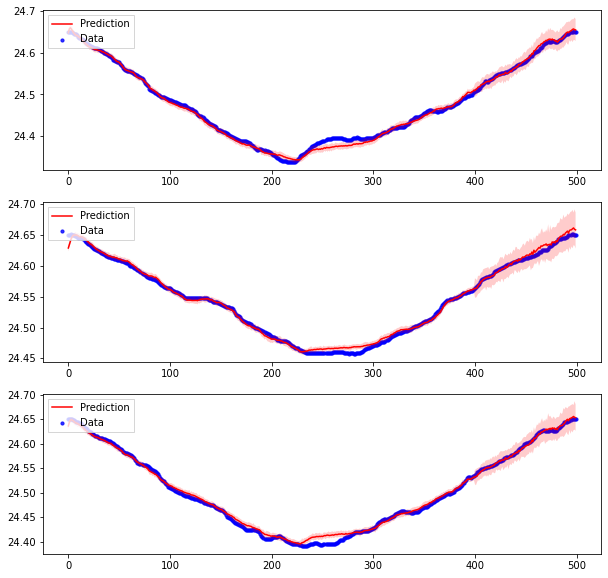

              MSE  R-squared       MAE
Average  0.000033   0.994926  0.004271
\begin{tabular}{lrrr}
\toprule
{} &       MSE &  R-squared &       MAE \\
\midrule
Average &  0.000033 &   0.994926 &  0.004271 \\
\bottomrule
\end{tabular}

              MSE  R-squared       MAE
sample1  0.000047   0.994393  0.005169
sample2  0.000018   0.995262  0.003367
sample3  0.000033   0.995122  0.004278


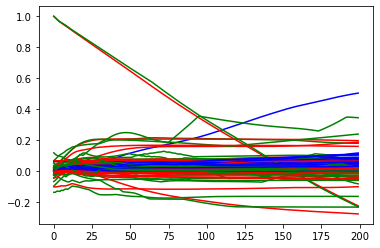

In [91]:
longitude_three_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[1]['longitude']), np.asarray(data_endo[2]['longitude'])]).T
#print(first_workout_data.shape)

x = torch.FloatTensor(longitude_three_data).reshape(1, *longitude_three_data.shape)
#print(x)
x_train = torch.FloatTensor(longitude_three_data[:450]).reshape(1, 450, longitude_three_data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(longitude_three_data[450:500]).reshape(1, 50, longitude_three_data.shape[1])
#print(x_val)

dkf = RNDKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(longitude_three_data.shape[0]),
        longitude_three_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()


mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)
print(df.to_latex())

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)
#print(df.to_latex())

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()